## Campaign altitude




In [34]:
# imports from packages
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
from matplotlib_map_utils.core import north_arrow
import matplotlib.dates as mdates
from windrose import WindroseAxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os
from os import listdir
from os.path import isfile, join
import datetime
import sys # to test parts of code with sys.exit()
import math
import seaborn as sns

import functions
import numb_conc # functions relating to number concenctration calculations
import plots


In [35]:
# --- Global formatting/settings/variables

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# --- Thresholds for in-cloud values
# ----- Water content threshold
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

# ----- Number concentration threshold
# Following table 2 from Evans et al 2025:
# Ice concentration threshold to define ice = 0.1 L-1 (or m-3) (NT100 is given in m-3)
# Cdp drop concentration to define liquid = 2 cm-3 (numb conc corrected is given in cm-3)

n_ice_th = 0.1
n_drp_th = 2

# --- Select preselect options

# ----- In cloud threshold method
# Options:
# - 'LWC_th' based on only LWC
# - 'TWC_th' based on only TWC
# - 'LWC_IWC_th' based on LWC and IWC
# - 'N_th' based on number concentration from both CDP and CIP
th_method = 'LWC_IWC_th'

# --- Preselection options

#preselect = False # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)
preselect = True # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)

preopt = ''
rm_cirrus = True # remove cirrus by only looking at
rm_c_T = -35
marine = True # only use marine values (values larger than given lat)
m_lat = 70
rm_precip = False # remove precip based on selection
rm_roll = True # only use values where Rol is less than 5
roll_th = 5


# set saving paths based on preselection options
if preselect == False:
    pre_text=''
    if rm_cirrus == True:
        preopt = preopt + f'rmCir{rm_c_T}_'
        pre_text = pre_text + f'Cirrus removed (>{rm_c_T}), '
    if marine == True:
        preopt = preopt + f'mar{m_lat}_'
        pre_text = pre_text + f'only marine (lat>70), '
    if rm_precip == True:
        preopt = preopt + f'rmPre{m_lat}_'
        pre_text = pre_text + f'Precip removed, '
    if rm_roll == True:
        preopt = preopt + f'rmRoll{roll_th}_'
        pre_text = pre_text + f'Roll removed, '
        
    save_path = '/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/Pre_selection/' #+preopt 

else:
    #save_path = 'save_images/Alldata/'
    #save_path = 'save_images/EGU/'
    save_path = '/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/'
    pre_text = 'no preselect'


print(pre_text)
extr_txt = ''
#extr_txt = '(allin_off)'

no preselect


In [36]:
# --- Data import
# Import the processed data:
#main_path = '/home/ninalar/Documents/MC2/Results_2022-islas/Processed/ISLAS_processed' # regular path
main_path = '/home/ninalar/Documents/MC2/Results_2022-islas/Processed/with_distance_from_ice' # path with sea ice distance
file_struct = '/microphy_5s_*.nc' # structure of cip text-file names

sic_path = '/home/ninalar/Documents/MC2/procIslasMicrophy/sea_ice_satellite/asi-n6250-'
sic_file_struct = '-5.4_regridded.nc'


# get all the .nc files in the main path
files = glob.glob(os.path.join(main_path, file_struct))
files = glob.glob(main_path+file_struct)

# Exclude the file containing 'IS22-09' (flew over land)
files_to_exclude = [f for f in files if 'IS22-09' in os.path.basename(f)]
files_to_include = [f for f in files if f not in files_to_exclude]


ds = xr.open_mfdataset(files_to_include, combine='by_coords', combine_attrs='drop_conflicts') # drop the IS22-09 flight

# sea ice information from satellite
min_date = '20220322'
#min_date = '20220324'
#min_date = '20220326'
#min_date = '20220329'
#min_date = '20220330'
#min_date = '20220331'
max_date = '20220403'
sic_max_ds = xr.open_dataset(sic_path  + max_date + sic_file_struct)
sic_max_ds.close()
sic_min_ds = xr.open_dataset(sic_path  + min_date + sic_file_struct)
sic_min_ds.close()

# rename data variable and update attributes
sic_max_ds['sic'] = sic_max_ds['__xarray_dataarray_variable__'].assign_attrs(units="Percent", description="Sea Ice Concentration")
sic_max_ds = sic_max_ds.drop_vars(['__xarray_dataarray_variable__'])
sic_min_ds['sic'] = sic_min_ds['__xarray_dataarray_variable__'].assign_attrs(units="Percent", description="Sea Ice Concentration")
sic_min_ds = sic_min_ds.drop_vars(['__xarray_dataarray_variable__'])

# add some attributes
sic_max_ds.attrs['date'] = max_date
sic_max_ds.attrs['file'] = f'asi-n6250-{min_date}-5.4_regridded.nc'
sic_min_ds.attrs['date'] = min_date
sic_min_ds.attrs['file'] = f'asi-n6250-{min_date}-5.4_regridded.nc'


In [37]:
ds

<xarray.Dataset> Size: 123MB
Dimensions:                 (time: 22392, Vector64: 64, Vector40: 40,
                             CDP_Bin: 30, step: 201)
Coordinates:
  * time                    (time) datetime64[ns] 179kB 2022-03-22T11:37:21 ....
    lat                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    lon                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    alt                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    islasid                 (time) <U7 627kB 'IS22-02' 'IS22-02' ... 'IS22-11'
Dimensions without coordinates: Vector64, Vector40, step
Data variables: (12/80)
    base_time               (time) datetime64[ns] 179kB 2022-03-22T11:37:21 ....
    utc_time                (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    TAS                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 6MB dask.array<chunksize=(2358, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SA                      (time, Vector64) float32 6MB dask.array<chunksize=(2358, 64), meta=np.ndarray>
    ...                      ...
    LWC corr                (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SV                      (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SV_CDP                  (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    distance_from_ice       (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    lon_step                (step, time) float32 18MB dask.array<chunksize=(201, 2358), meta=np.ndarray>
    lat_step                (step, time) float32 18MB dask.array<chunksize=(201, 2358), meta=np.ndarray>
Attributes:
    date_modified:            2025-07-02
    Joint sample rate (sek):  5.0

In [38]:
#---- Select incloud, relevant values

# commenting out all other masks for the EGU version

# Masks for different types of selections 
#lwc_mask = (ds['LWC corr']>=lwc_th).compute() # mask the values based on lwc according to threshold
#twc_mask = (ds['TWC']>=lwc_th).compute() # mask the values based on twc according to threshold
lwc_iwc_mask = ((ds['LWC corr']>= lwc_th)|(ds['IWC100']>= lwc_th)).compute() # mask the values based on lwc or iwc according to threshold
#nt_mask = ((ds['Number Conc corr']>= n_drp_th)|(ds['NT100']>= n_ice_th)).compute()


# --- First selection: all data or only lower clouds/relevant data, only marine data
if preselect == True:
    # select only marine values (lat higher than 70)
    if marine == True:
        marinelat_mask = (ds['lat']>=m_lat).compute()
        ds_relevant = ds.where(marinelat_mask, drop = True)

    if rm_cirrus == True:
        # select only values where temperature is higher than selected temperature (avoid cirrus)
        cirrusT_mask = (ds['T']>=rm_c_T).compute()
        ds_relevant = ds_relevant.where(cirrusT_mask, drop = True)

    if rm_roll == True:
        # select only values where roll is less than selected threshold
        roll_mask = (ds['ROLL']<=roll_th).compute()
        ds_relevant = ds_relevant.where(roll_mask, drop=True)

    
else:
    ds_relevant = ds

# ---- Second selection: what should be considered in-cloud?
# th_method is used to selecting the selection criteria and is added to saved plots for organizing
if th_method == 'LWC_th':
    # only lwc have to be larger than threshold, use lwc mask
    incloud_mask = lwc_mask
    th = f'{lwc_th} m^-3, (LWC)'
elif th_method == 'TWC_th':
    # twc have to be larger than threshold value, use twc mask
    incloud_mask = twc_mask
    th = f'{lwc_th} m^-3, (TWC)'
elif th_method == 'LWC_IWC_th':
    # either lwc or iwc needs to be larger than the threshold, use lwc_iwc_mask
    incloud_mask = lwc_iwc_mask
    th = f'{lwc_th} m^-3, (LWC or IWC)'
elif th_method == 'N_th':
    incloud_mask = nt_mask
    th = f'Nt_cdp>{n_drp_th} cm^-3, Nt_cip100>{n_ice_th} L^-1'
else:
    print('WARNING: in-cloud threshold method not defined!')

# create the selected dataset based on selected mask
ds_incloud = ds_relevant.where(incloud_mask, drop = True)

# --- Third selection: selection and removal of precip values

if rm_precip == True:
    # use the remove precip in all the plots
    ds_incloud = ds_incloud.where(~precip_mask, drop=True)
    
# store precip/noprecip separately: (Dont care about precip for EGU
#ds_incloud_noprecip = ds_incloud.where(~precip_mask, drop=True)# Remove precip from incloud
#ds_precip= ds_incloud.where(precip_mask, drop = True) # save only precip

# Printing sizes of datasets for overview:
print(f'Full dataset size: {len(ds.time)}')
print(f'Relevant(over sea, warmer than -35) dataset size: {len(ds_relevant.time)}')
print(f'In-cloud threshold: {lwc_th} g/m3')
#print(f'Incloud dataset (LWC_th) size: {len(ds_relevant.where(lwc_mask, drop=True).time)}')
#print(f'Incloud dataset (TWC_th) size: {len(ds_relevant.where(twc_mask, drop=True).time)}')
print(f'Incloud dataset (LWC_IWC_th) size: {len(ds_relevant.where(lwc_iwc_mask, drop=True).time)}')
print(f'Used dataset: {th_method}, size:{len(ds_incloud.time)}')



Full dataset size: 22392
Relevant(over sea, warmer than -35) dataset size: 11572
In-cloud threshold: 0.01 g/m3
Incloud dataset (LWC_IWC_th) size: 5314
Used dataset: LWC_IWC_th, size:5314


In [39]:
# in-cloud "sample distances" based on 5 sek values over the max an min TAS
print(f'Min TAS: {ds_incloud.TAS.values.min()} m/s')
print(f'Min sample distance (5 s sample): {ds_incloud.TAS.values.min()*5} m')
print(f'Max TAS: {ds_incloud.TAS.values.max()} m/s')
print(f'Max sample distance (5 s sample): {ds_incloud.TAS.values.max()*5} m')
print(f'max incloud altitude: {ds_incloud.alt.values.max()} m')
print(f'min incloud altitude: {ds_incloud.alt.values.min()} m')

Min TAS: 59.0 m/s
Min sample distance (5 s sample): 295.0 m
Max TAS: 143.0 m/s
Max sample distance (5 s sample): 715.0 m
max incloud altitude: 4885.04052734375 m
min incloud altitude: 83.09110260009766 m


In [40]:
# in cloud time per flight
print(len(ds_incloud['time']))

obs = ds_incloud['time'].groupby('islasid').count()
print(obs)

5314
<xarray.DataArray 'time' (islasid: 9)> Size: 72B
array([1405,  192,  461,  581,  560,  547,  254,  524,  790])
Coordinates:
  * islasid  (islasid) object 72B 'IS22-02' 'IS22-03' ... 'IS22-10' 'IS22-11'


In [41]:
# creating the summary values for in cloud observations

# Get the number of in cloud observations per flight
c_df = ds_incloud['time'].groupby("islasid").count().to_dataframe()


# Get the max and min temperatures for the fligths incloud values
t_df = ds_incloud['T'].to_dataframe()
t_min = t_df.groupby("islasid").min()
t_max = t_df.groupby("islasid").max()

# Get the max, min and mean distance from sea ice for the fligths incloud values
dist_df = ds_incloud['distance_from_ice'].to_dataframe()
dist_min = dist_df.groupby("islasid").min()
dist_max = dist_df.groupby("islasid").max()
dist_mean = dist_df.groupby("islasid").mean()

# get the max and min altitude per flight

# get the max and mean LWC and IWC per flight
lwc_df = ds_incloud['LWC corr'].to_dataframe()
lwc_max = lwc_df.groupby("islasid").max()
lwc_mean = lwc_df.groupby("islasid").mean()
iwc_df = ds_incloud['IWC100'].to_dataframe()
iwc_max = iwc_df.groupby("islasid").max()
iwc_mean = iwc_df.groupby("islasid").mean()

summary_df = pd.concat([c_df,t_min['T'],t_max['T'],
                        dist_min['distance_from_ice'], dist_max['distance_from_ice'],dist_mean['distance_from_ice'],
                        lwc_max['LWC corr'],lwc_mean['LWC corr'],
                        iwc_max['IWC100'],iwc_mean['IWC100']],axis=1)
summary_df.columns = ['count','T_min','T_max','Dist_min','Dist_max','Dist_mean','LWC max', 'LWC mean','IWC max','IWC_mean']
print(summary_df)
#min_time = ds['time'].groupby('islasid').min()
#min_time.values







         count      T_min      T_max  Dist_min  Dist_max   Dist_mean  \
islasid                                                                
IS22-02   1405 -24.759544  -6.053902     825.0    1125.0  918.425793   
IS22-03    192 -34.993595 -14.920144     125.0     200.0  166.927083   
IS22-04    461 -30.063189 -15.794225      25.0     275.0  236.225597   
IS22-05    581 -26.479782  -9.027604     350.0     525.0  407.487091   
IS22-06    560 -23.890352  -6.404769     600.0     875.0  647.008929   
IS22-07    547 -34.868954  -5.072329     325.0     725.0  388.619744   
IS22-08    254 -24.148149  -7.082026     450.0     575.0  510.925197   
IS22-10    524 -22.013615 -11.875039    -125.0     150.0   10.591603   
IS22-11    790 -22.264254 -10.934270    -125.0     225.0   60.189873   

          LWC max  LWC mean   IWC max  IWC_mean  
islasid                                          
IS22-02  0.572664  0.024311  1.544768  0.066177  
IS22-03  0.406732  0.042463  0.701328  0.105875  
IS22-04

In [42]:
# --- Preparations for altitude based plots
# create categorical altitude variable based on altitude values (for in-cloud, relevant and precip data

# Define the bin edges for the altitude (based on the incloud data
altitude_bins = np.arange(0, ds_incloud['alt'].max() + 300, 300) # based on max values in data
bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2

# need to add altitude binning information(based on in-cloud values) to all datasets 
def add_alt_bins(ds, altitude_bins):
    # digitize altitude data into bins
    alt_bin_indices = np.digitize(ds['alt'], bins = altitude_bins)

    ds = ds.assign_coords(altitude_bin=('time', alt_bin_indices)) # on 'time' dimension

    # Label bins by midpoints
    bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
    ds['altitude_bin'].data = bin_labels[alt_bin_indices - 1]
    ds.coords['altitude_bin']=ds.coords['altitude_bin'].astype(int)
    return ds

ds_incloud = add_alt_bins(ds_incloud, altitude_bins) # add altitude binning information

# Define the bin edges for the distance from sea ice
#dist_bins = np.arange(dist_df['distance_from_ice'].min()-25,dist_df['distance_from_ice'].max()+175,250) # gives 6 distance bins of 250 km
#dist_bins = np.arange(dist_df['distance_from_ice'].min()-25,dist_df['distance_from_ice'].max()+175,200) # gives 8 distance bins of 200 km
dist_bins = np.arange(dist_df['distance_from_ice'].min(),dist_df['distance_from_ice'].max()+125,125) # gives 11 distance bins of 125 km

def add_dist_bins(ds, dist_bins):
    # digitize altitude data into bins
    dist_bin_indices = np.digitize(ds['distance_from_ice'], bins = dist_bins)
   
    ds = ds.assign_coords(dist_bin=('time', dist_bin_indices)) # on 'time' dimension

    # adjust indices to 0-based
    dist_bin_indices_adj = dist_bin_indices - 1

    # Only handle valid indices
    dist_bin_labels = np.full_like(dist_bin_indices_adj, fill_value=np.nan, dtype=float)
    valid_ind = dist_bin_indices_adj < len(dist_bins)
    dist_bin_labels[valid_ind] = dist_bins[dist_bin_indices_adj[valid_ind]]

    # Label data
    ds['dist_bin'].data = dist_bin_labels
    ds.coords['dist_bin'] = ds.coords['dist_bin'].astype(int)
    return ds

ds_incloud = add_dist_bins(ds_incloud, dist_bins) # add distance binning information

# define bin edges for temperature bins (5 degrees)
temp_bins = np.arange(-35, 0, 5) # selected out data below -35 allready

def add_t_bins(ds, temp_bins):
    # digitize altitude data into bins
    temp_bin_indices = np.digitize(ds['T'], bins = temp_bins)
   
    ds = ds.assign_coords(temp_bin=('time', temp_bin_indices)) # on 'time' dimension

    # adjust indices to 0-based
    temp_bin_indices_adj = temp_bin_indices - 1

    # Only handle valid indices
    temp_bin_labels = np.full_like(temp_bin_indices_adj, fill_value=np.nan, dtype=float)
    valid_ind = temp_bin_indices_adj < len(temp_bins)
    temp_bin_labels[valid_ind] = temp_bins[temp_bin_indices_adj[valid_ind]]

    # Label data
    ds['temp_bin'].data = temp_bin_labels
    ds.coords['temp_bin'] = ds.coords['temp_bin'].astype(int)
    return ds

ds_incloud = add_t_bins(ds_incloud, temp_bins) # add temp binning information

# relevant clouds (all data)
alt_mask = (ds_relevant['alt'] <= altitude_bins.max()).compute()
ds_relevant = ds_relevant.where(alt_mask, drop = True) 
ds_relevant = add_alt_bins(ds_relevant, altitude_bins) # add altitude binning information
ds_relevant = add_dist_bins(ds_relevant, dist_bins) # add distance binning information

In [43]:
ds_incloud

<xarray.Dataset> Size: 29MB
Dimensions:                 (time: 5314, Vector64: 64, Vector40: 40,
                             CDP_Bin: 30, step: 201)
Coordinates:
  * time                    (time) datetime64[ns] 43kB 2022-03-22T11:39:01 .....
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 21kB 70.2 70.22 70.23 ... 74.96 74.95
    lon                     (time) float32 21kB 20.38 20.37 ... 20.88 20.88
    alt                     (time) float32 21kB 3.863e+03 3.866e+03 ... 840.7
    islasid                 (time) <U7 149kB 'IS22-02' 'IS22-02' ... 'IS22-11'
    altitude_bin            (time) int64 43kB 3750 3750 3750 ... 450 750 750
    dist_bin                (time) int64 43kB 1125 1125 1125 1125 ... -125 0 0
    temp_bin                (time) int64 43kB -20 -20 -20 -20 ... -15 -15 -15
Dimensions without coordinates: Vector64, Vector40, step
Data variables: (12/80)
    base_time               (time) datetime64[ns] 43kB 2022-03-22T11:37:21 .....
    utc_time                (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    TAS                     (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 1MB dask.array<chunksize=(1928, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SA                      (time, Vector64) float32 1MB dask.array<chunksize=(1928, 64), meta=np.ndarray>
    ...                      ...
    LWC corr                (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SV                      (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SV_CDP                  (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    distance_from_ice       (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    lon_step                (step, time) float32 4MB dask.array<chunksize=(201, 1928), meta=np.ndarray>
    lat_step                (step, time) float32 4MB dask.array<chunksize=(201, 1928), meta=np.ndarray>
Attributes:
    date_modified:            2025-07-02
    Joint sample rate (sek):  5.0

In [44]:
# datapoints per altitude bins and statistics
print(f'#datapoints per altitudebin: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values}')
print(f'Min #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.min()}')
print(f'Max #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.max()}')
print(f'Mean #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.mean()}')

#datapoints per altitudebin: [ 219 1279  503  538 1014  536  215  122   32  425   23   26   93  281
    7    1]
Min #datapoints: 1
Max #datapoints: 1279
Mean #datapoints: 332.125


In [45]:
# --- Functions (add to file later)


def plot_flight_obs(ds, ds_incloud, sic_max_ds,sic_min_ds, obs, lat_bands='',title='', savefile = ''):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    #colors for flights (for consistent coloring in plots)
    c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:orange',
              'IS22-03':'tab:cyan',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:pink',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:red',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:grey',
              'IS22-10':'tab:blue',
              'IS22-11':'tab:green'}

    
    # --- Set up figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get the flightids
    flights = np.unique(ds.islasid.values)

    for flight in flights:
        
        # Select out the data connected with the flight
        f1_mask = (ds['islasid']==flight).compute()
        ds_f = ds.where(f1_mask, drop = True)
        f1_mask = (ds_incloud['islasid']==flight).compute()
        ds_incloud_f = ds_incloud.where(f1_mask, drop = True)


        # get datavalues for plotting lines
        lat_values = ds_f['lat'].values
        lon_values = ds_f['lon'].values

        # get datavalues for plotting incloud values
        obs_lat_values = ds_incloud_f['lat'].values
        obs_lon_values = ds_incloud_f['lon'].values
        
        if obs == True:
            # plot all lat-lon points and where incloud obs
            ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], alpha=0.01, transform = data_projection)
            ax.scatter(obs_lon_values, obs_lat_values, marker='o',label=flight, c= c_flights[flight], transform = data_projection)
        else:
            ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], transform = data_projection, label = flight)

    if lat_bands!='':
        # Draw latitude bands
        for lat_band in lat_bands:
            ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
            if lat_band in [lat_min, lat_max]:
                lat_text = round(lat_band, 2)
            else:
                lat_text = lat_band
            ax.text(28, lat_band-0.9, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='k', 
                    rotation=30, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        # Text for northern and southern marine

        ax.text(30, 75.5, "Northern \n marine region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='tab:blue', 
                    rotation=30)
        ax.text(30, 71.5, "Southern \n marine \n region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='tab:red', 
                    rotation=30)
    
    # add sea ice concentration
    cs = ax.contour(sic_max_ds['lon'],sic_max_ds['lat'],sic_max_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashed')
    contour_legend_max = mlines.Line2D([], [], color='tab:grey',linestyle='--', label='25% Sea Ice \n concentration')
    cs_m = ax.contour(sic_max_ds['lon'],sic_min_ds['lat'],sic_min_ds['sic'], transform=ccrs.PlateCarree(),levels=[15.], colors='tab:grey', linestyles='dashdot')
    contour_legend_min = mlines.Line2D([], [], color='tab:grey',linestyle='-.', label='25% Sea Ice \n concentration')
    
    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='yellow', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    if title!='':
        ax.set_title(f'{title}', fontsize = 25)

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    title_proxy = Rectangle((0,0), 0, 0, color='w') # create second "title"
    # append handles and labels with new title
    handles.append(title_proxy)
    labels.append('25% Sea Ice conc.')
    #append with sea ice information
    handles.append(contour_legend_max)
    max_date_obj = pd.to_datetime(sic_max_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Max: {max_date_obj.strftime('%b')} {max_date_obj.strftime('%d')}')
    handles.append(contour_legend_min)
    min_date_obj = pd.to_datetime(sic_min_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Min: {min_date_obj.strftime('%b')} {min_date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=11, title = 'ISLAS Flight')
    plt.tight_layout()
    if savefile !='':
        plt.savefig(savefile, bbox_inches='tight')

def plot_flight_obs_single(lat_bands,full_extent, ds, ds_incloud, sic_ds, ax):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    #colors for flights (for consistent coloring in plots)
    c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:orange',
              'IS22-03':'tab:cyan',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:pink',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:red',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:grey',
              'IS22-10':'tab:blue',
              'IS22-11':'tab:green'}


    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get the flightids
    flight = np.unique(ds.islasid.values)[0]

    # get datavalues for plotting lines
    lat_values = ds['lat'].values
    lon_values = ds['lon'].values

    # get datavalues for plotting incloud values
    obs_lat_values = ds_incloud['lat'].values
    obs_lon_values = ds_incloud['lon'].values
        
    # plot all lat-lon points and where incloud obs
    ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], alpha=0.01, transform = data_projection)
    ax.scatter(obs_lon_values, obs_lat_values, marker='o',label=flight, c= c_flights[flight], transform = data_projection)

    # Draw latitude bands
    #for lat_band in lat_bands:
     #   ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
     #   if lat_band in [lat_min, lat_max]:
     #       lat_text = round(lat_band, 2)
     #   else:
     #       lat_text = lat_band
     #   ax.text(28, lat_band-0.9, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', color='k', 
     #           rotation=30, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Text for northern and southern marine
    #ax.text(30, 75.5, "Northern \n marine region", transform=ccrs.PlateCarree(), ha='center', va='bottom', color='tab:blue',rotation=30)
    #ax.text(30, 71.5, "Southern \n marine \n region", transform=ccrs.PlateCarree(), ha='center', va='bottom', color='tab:red',rotation=30)
    
    # add sea ice concentration
    cs = ax.contour(sic_ds['lon'],sic_ds['lat'],sic_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashed')
    contour_legend = mlines.Line2D([], [], color='tab:grey',linestyle='--', label='25% Sea Ice \n concentration')

    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='yellow', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent(full_extent)
    ax.gridlines()

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    title_proxy = Rectangle((0,0), 0, 0, color='w') # create second "title"
    #append with sea ice information
    handles.append(contour_legend)
    date_obj = pd.to_datetime(sic_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'25% Sea Ice conc.: {date_obj.strftime('%b')} {date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=11, title = 'ISLAS Flight')

    return c_flights[flight] # return the color for the flight to be used in other plots

def plot_lat_bands(lat_bands, ds, ds_incloud,sic_max_ds,sic_min_ds, title, savefile = ''):
    # Function to plot the observations per flight, and indicate the norhtern and southern region
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

   # coordinates of Kiruna TODO: remove?
    lat_kir = 67.8256
    lon_kir = 20.3351

    # set colors
    n_col='tab:blue'
    s_col='tab:red'
    
    # --- Set up figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get datavalues for plotting
    lat_values = ds['lat'].values
    lon_values = ds['lon'].values

    # select out northern marine in cloud values
    n_mask = (ds_incloud['region'] == 'north').compute()
    n_ds = ds_incloud.where(n_mask, drop=True)
    n_lat_values = n_ds['lat'].values
    n_lon_values = n_ds['lon'].values
    
    # select out southern marine in cloud values
    s_mask = (ds_incloud['region'] == 'south').compute()
    s_ds = ds_incloud.where(s_mask, drop=True)
    s_lat_values = s_ds['lat'].values
    s_lon_values = s_ds['lon'].values


    ax.scatter(lon_values, lat_values, marker='.',c='darkgrey', label='Flight path', transform = data_projection)
    ax.scatter(n_lon_values, n_lat_values, marker='o',c=n_col, label=f'Northern marine region \n in-cloud ({len(n_lon_values)} obs)', transform = data_projection)
    ax.scatter(s_lon_values, s_lat_values, marker='o',c=s_col, label=f'Southern marine region \n in-cloud ({len(s_lon_values)} obs)', transform = data_projection)

    # Draw latitude bands
    for lat_band in lat_bands:
        ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
        if lat_band in [lat_min, lat_max]:
            lat_text = round(lat_band, 2)
        else:
            lat_text = lat_band
        ax.text(28, lat_band-0.9, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='k', 
                rotation=30, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Text for northern and southern marine

    ax.text(30, 75.5, "Northern \n marine region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=n_col, 
                rotation=30)
    ax.text(30, 71.5, "Southern \n marine \n region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=s_col, 
                rotation=30)

    # add sea ice concentration
    cs = ax.contour(sic_max_ds['lon'],sic_max_ds['lat'],sic_max_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashed')
    contour_legend_max = mlines.Line2D([], [], color='tab:grey',linestyle='--', label='25% Sea Ice \n concentration')
    cs_m = ax.contour(sic_max_ds['lon'],sic_min_ds['lat'],sic_min_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashdot')
    contour_legend_min = mlines.Line2D([], [], color='tab:grey',linestyle='-.', label='25% Sea Ice \n concentration')
    
    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection) #add dot for kiruna, do not use
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    ax.set_title(f'{title}', fontsize = 25)

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    title_proxy = Rectangle((0,0), 0, 0, color='w') # create second "title"
    # append handles and labels with new title
    handles.append(title_proxy)
    labels.append('25% Sea Ice conc.')
    #append with sea ice information
    handles.append(contour_legend_max)
    max_date_obj = pd.to_datetime(sic_max_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Max: {max_date_obj.strftime('%b')} {max_date_obj.strftime('%d')}')
    handles.append(contour_legend_min)
    min_date_obj = pd.to_datetime(sic_min_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Min: {min_date_obj.strftime('%b')} {min_date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=12)
    plt.tight_layout()
    if savefile !='':
        plt.savefig(savefile, bbox_inches='tight')

def create_counts(ds, val, val_bins):
    # Function to create counts array tu use when making heatmaps. Keeps control of normalizations etc.
    # Input: 
    # --- ds: dataset, that at least have 'base_time' and an altitude as parameters
    # --- lat_bins: title to add to plot
    # output:
    # --- count_df: df ouf number of observations per latitudebin and altitude bin for the given dataset

    #grouped_data = ds['base_time'].groupby_bins('lat', bins=lat_bins) #group on lat binsbins
    grouped_data = ds['base_time'].groupby_bins(val, bins =val_bins)
    
    count_data = grouped_data.map(lambda group: group.groupby('altitude_bin').count())
    
    # reorganize data before plotting heatmap
    # - turn into dataframe - unstack to get correct array structure  
    count_df = count_data.to_dataframe().unstack()
    
    # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
    count_df = count_df.T.reset_index(level=0, drop = True)
    # -  make sure all possible altitude bins are represented, fill with 0 - reverse order of altitudes
    count_df = count_df.reindex(bin_labels, fill_value=0).iloc[::-1] #
    count_df = count_df.fillna(0) # set nan to 0 (for easier plot management)
    count_df = count_df.astype(int) # set the count to int
    count_df = count_df.iloc[:, ::-1] # reverse the columns to get the northern most values to the left
    #fix labels 
    new_labels = [f"[{label.right}, {label.left})" for label in count_df.columns]
    count_df.columns = new_labels
    
    return count_df

def calculate_slf(ds, iwc_param, lwc_param):
    """Calculate Supercooled liquid fraction(SLF) from given IWC and LWC parameters

    Parameters
    ----------
    ds
        xarray dataset that includes at least one IWC parameter and at least one LWC parameter
    iwc_param
        Name of IWC parameter to use for calculation of SLF
    lwc_param
        Name of LWC parameter to use for calculation of SLF

    Returns
    -------
    ds
        Updated xarray dataset that includes TWC and SLF calculated from the given IWC and LWC parameters
    """
    ds['TWC'] = ds[iwc_param]+ds[lwc_param] # first calculate TWC
    # update TWC attributes
    ds['TWC'].attrs['longname']='Total Water Content'
    ds['TWC'].attrs['unit']='g/m^3'
    ds['TWC'].attrs['description']='Sum of Liquid and Ice Water Content'
    ds['TWC'].attrs['calculated from']=[iwc_param,lwc_param]

    ds['SLF'] = (ds[lwc_param]/ds['TWC'])*100 # calculate SLF in percent
    ds['SLF'].attrs['longname']='Supercooled Liquid Fraction'
    ds['SLF'].attrs['unit']='Percent'
    ds['SLF'].attrs['description']='Liquid Water Content divided by Total Water Content'
    ds['SLF'].attrs['calculated from']=[lwc_param, 'TWC']

    
    return ds

In [46]:
# Calculate SLF (Korolev version)
ds_incloud = calculate_slf(ds_incloud,'IWC100','LWC corr')

# bin on 5% SLF
# define SLF bins
slf_bins = np.arange(0,105,5)

def add_slf_bins(ds, slf_bins):
    # digitize slf data into bins
    slf_bin_indices = np.digitize(ds['SLF'], bins = slf_bins)
    
    ds = ds.assign_coords(slf_bin=('time', slf_bin_indices)) # on 'time' dimension

    # adjust indices to 0-based
    slf_bin_indices_adj = slf_bin_indices - 1
  
    # Only handle valid indices
    slf_bin_labels = np.full_like(slf_bin_indices_adj, fill_value=np.nan, dtype=float)
    valid_ind = slf_bin_indices_adj < len(slf_bins)
    slf_bin_labels[valid_ind] = slf_bins[slf_bin_indices_adj[valid_ind]]

    # Label data
    ds['slf_bin'].data = slf_bin_labels
    ds.coords['slf_bin'] = ds.coords['slf_bin'].astype(int)
    return ds

ds_incloud = add_slf_bins(ds_incloud, slf_bins) # add distance binning information

In [47]:
ds_incloud

<xarray.Dataset> Size: 29MB
Dimensions:                 (time: 5314, Vector64: 64, Vector40: 40,
                             CDP_Bin: 30, step: 201)
Coordinates:
  * time                    (time) datetime64[ns] 43kB 2022-03-22T11:39:01 .....
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 21kB 70.2 70.22 70.23 ... 74.96 74.95
    lon                     (time) float32 21kB 20.38 20.37 ... 20.88 20.88
    alt                     (time) float32 21kB 3.863e+03 3.866e+03 ... 840.7
    islasid                 (time) <U7 149kB 'IS22-02' 'IS22-02' ... 'IS22-11'
    altitude_bin            (time) int64 43kB 3750 3750 3750 ... 450 750 750
    dist_bin                (time) int64 43kB 1125 1125 1125 1125 ... -125 0 0
    temp_bin                (time) int64 43kB -20 -20 -20 -20 ... -15 -15 -15
    slf_bin                 (time) int64 43kB 0 0 0 0 0 0 0 ... 85 70 95 95 0 0
Dimensions without coordinates: Vector64, Vector40, step
Data variables: (12/82)
    base_time               (time) datetime64[ns] 43kB 2022-03-22T11:37:21 .....
    utc_time                (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    TAS                     (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 1MB dask.array<chunksize=(1928, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SA                      (time, Vector64) float32 1MB dask.array<chunksize=(1928, 64), meta=np.ndarray>
    ...                      ...
    SV_CDP                  (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    distance_from_ice       (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    lon_step                (step, time) float32 4MB dask.array<chunksize=(201, 1928), meta=np.ndarray>
    lat_step                (step, time) float32 4MB dask.array<chunksize=(201, 1928), meta=np.ndarray>
    TWC                     (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SLF                     (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
Attributes:
    date_modified:            2025-07-02
    Joint sample rate (sek):  5.0

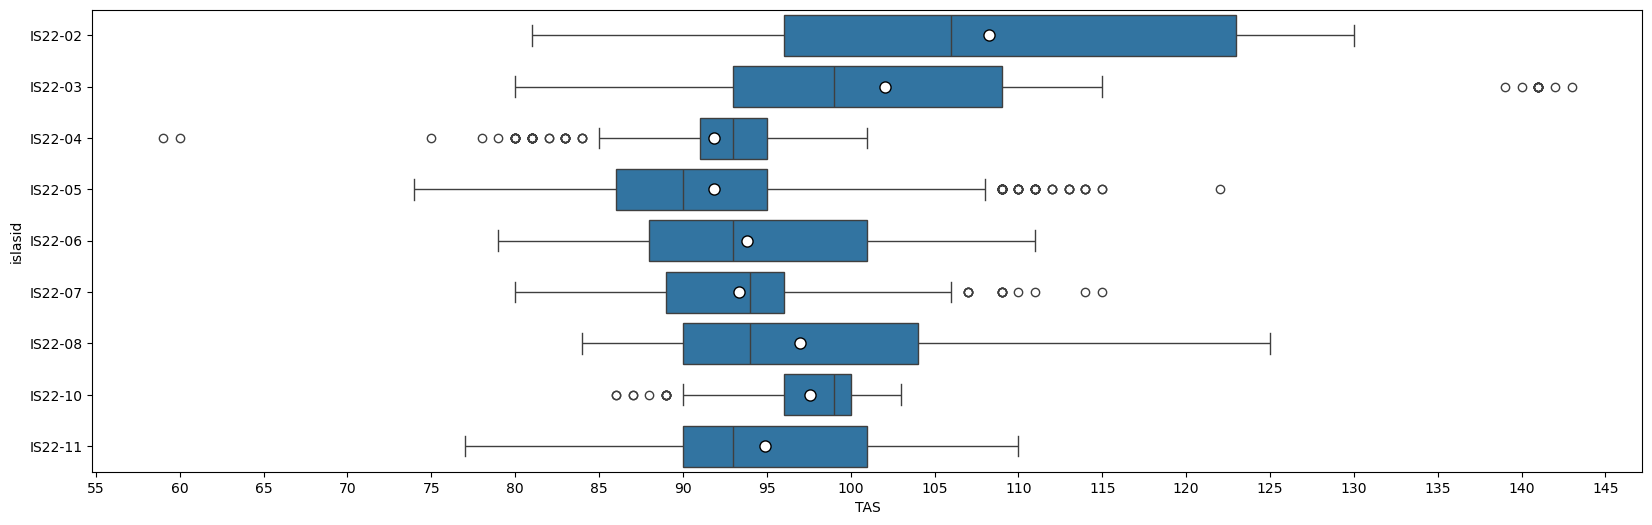

               lat        lon          alt  altitude_bin    dist_bin  \
islasid                                                                
IS22-02  71.567596  20.188711  2693.368896   2636.049822  865.569395   
IS22-03  77.056076  10.836925  1257.637817   1178.125000  125.000000   
IS22-04  78.018990   8.256637  1020.746521   1079.284165  186.822126   
IS22-05  72.797485  17.520159  1169.345337   1185.800344  378.872633   
IS22-06  70.960213  16.548471  1288.433228   1341.428571  619.642857   
IS22-07  71.903069  18.713125  1240.245117   1212.340037  307.815356   
IS22-08  72.241829  21.372391  1370.184326   1367.716535  472.440945   
IS22-10  75.960823  16.569960   386.363525    487.213740  -41.269084   
IS22-11  76.371178  14.287055   537.239380    541.518987    2.689873   

          temp_bin    slf_bin         TAS  
islasid                                    
IS22-02 -18.035587  13.135231  108.227043  
IS22-03 -26.432292  22.786458  102.041664  
IS22-04 -26.464208  11.702820  

In [48]:
# summary of flights TAS
mean_temperature = ds_incloud['T'].groupby('islasid').mean()
mean_temperature.values



# boxplot of TAS per flight
tas = ds_incloud['TAS'].to_dataframe()

fig, ax = plt.subplots(figsize=(20,6))

t_plot = sns.boxplot(data=tas, x="TAS", y="islasid", showmeans=True, 
            meanprops = {'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})

t_plot.set_xticks([55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145])

savefile =  save_path + f'TAS_distribution.png'
plt.savefig(savefile, bbox_inches='tight')
plt.show()

means = tas.groupby("islasid").mean()

print(means)

## Plots

In [49]:
lon_min = ds_incloud.lon.values.min() 
lon_max = ds_incloud.lon.values.max()

sample_rate = int(ds_incloud.attrs['Joint sample rate (sek)']) # get sample rate for file naming

print(lon_min, lon_max)

6.9966335 24.792715


In [50]:
ds_incloud

<xarray.Dataset> Size: 29MB
Dimensions:                 (time: 5314, Vector64: 64, Vector40: 40,
                             CDP_Bin: 30, step: 201)
Coordinates:
  * time                    (time) datetime64[ns] 43kB 2022-03-22T11:39:01 .....
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 21kB 70.2 70.22 70.23 ... 74.96 74.95
    lon                     (time) float32 21kB 20.38 20.37 ... 20.88 20.88
    alt                     (time) float32 21kB 3.863e+03 3.866e+03 ... 840.7
    islasid                 (time) <U7 149kB 'IS22-02' 'IS22-02' ... 'IS22-11'
    altitude_bin            (time) int64 43kB 3750 3750 3750 ... 450 750 750
    dist_bin                (time) int64 43kB 1125 1125 1125 1125 ... -125 0 0
    temp_bin                (time) int64 43kB -20 -20 -20 -20 ... -15 -15 -15
    slf_bin                 (time) int64 43kB 0 0 0 0 0 0 0 ... 85 70 95 95 0 0
Dimensions without coordinates: Vector64, Vector40, step
Data variables: (12/82)
    base_time               (time) datetime64[ns] 43kB 2022-03-22T11:37:21 .....
    utc_time                (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    TAS                     (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 1MB dask.array<chunksize=(1928, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SA                      (time, Vector64) float32 1MB dask.array<chunksize=(1928, 64), meta=np.ndarray>
    ...                      ...
    SV_CDP                  (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    distance_from_ice       (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    lon_step                (step, time) float32 4MB dask.array<chunksize=(201, 1928), meta=np.ndarray>
    lat_step                (step, time) float32 4MB dask.array<chunksize=(201, 1928), meta=np.ndarray>
    TWC                     (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SLF                     (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
Attributes:
    date_modified:            2025-07-02
    Joint sample rate (sek):  5.0

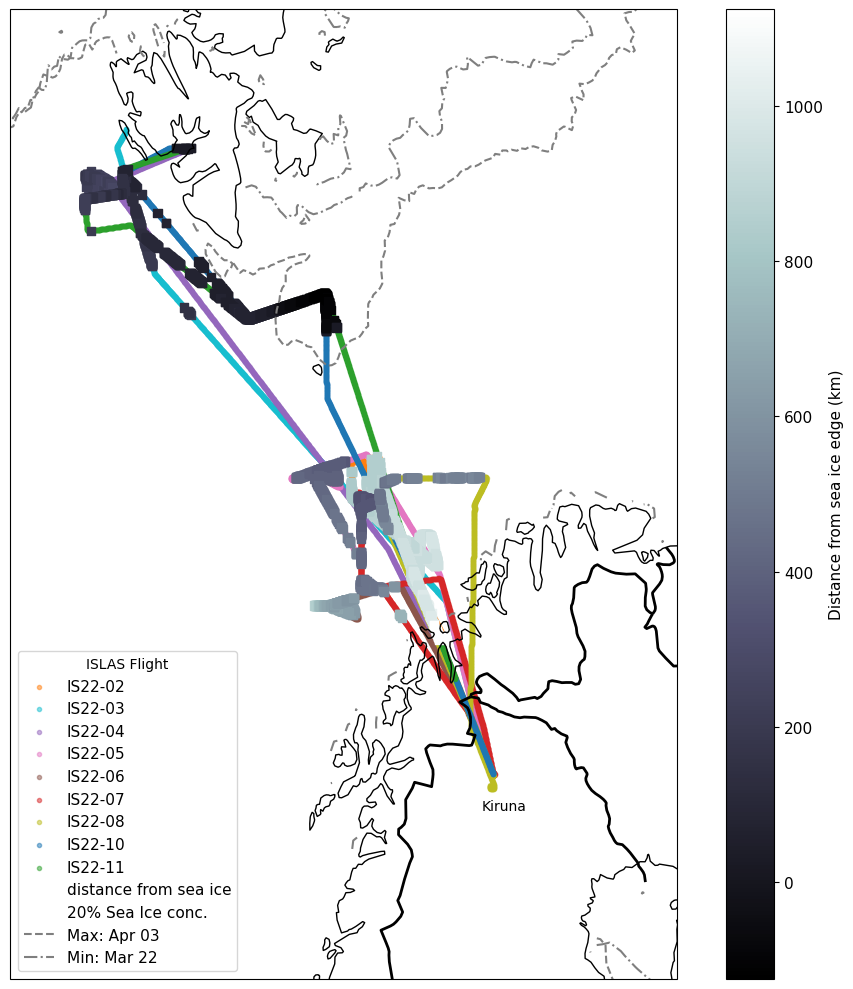

In [51]:
# --- group by distance from sea ice 100 km
def plot_obs_sic_dist(ds, ds_incloud, sic_max_ds,sic_min_ds, title="", savefile = ''):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- ds: full original dataset for plotting flightpaths
    # --- ds_incloud: the in_cloud values of the dataset
    # --- sic_max_ds: sea ice concnetration data for the day with the max sic
    # --- sic_min_ds: sea ice concentration data for the day with the min sic
    # --- title: title to add to plot
    # --- obs: True or false whether or not to include the observations in the plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    #colors for flights (for consistent coloring in plots)
    c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:orange',
              'IS22-03':'tab:cyan',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:pink',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:red',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:grey',
              'IS22-10':'tab:blue',
              'IS22-11':'tab:green'}

    
    # --- Set up figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get the flightids
    flights = np.unique(ds.islasid.values)

    for flight in flights:
        
        # Select out the data connected with the flight
        f1_mask = (ds['islasid']==flight).compute()
        ds_f = ds.where(f1_mask, drop = True)
        f1_mask = (ds_incloud['islasid']==flight).compute()
        ds_incloud_f = ds_incloud.where(f1_mask, drop = True)


        # get datavalues for plotting lines
        lat_values = ds_f['lat'].values
        lon_values = ds_f['lon'].values
        
        # plot all lat-lon points for flights in color
        ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], alpha = 0.5,label=flight, transform = data_projection)
    
    # plot the in cloud observations with color as distance from sea ice
    incloud_obs =ax.scatter(ds_incloud['lon'].values, ds_incloud['lat'].values, marker='s', c=ds_incloud['distance_from_ice'],cmap='bone', label='distance from sea ice',transform = data_projection)
    cbar = plt.colorbar(incloud_obs, label='Distance from sea ice edge (km)')
    cbar.ax.tick_params(labelsize=11)
    cbar.set_label('Distance from sea ice edge (km)',size=11)
    
    # add sea ice concentration
    cs = ax.contour(sic_max_ds['lon'],sic_max_ds['lat'],sic_max_ds['sic'], transform=ccrs.PlateCarree(),levels=[20.], colors='tab:grey', linestyles='dashed')
    contour_legend_max = mlines.Line2D([], [], color='tab:grey',linestyle='--', label='20% Sea Ice \n concentration')
    cs_m = ax.contour(sic_min_ds['lon'],sic_min_ds['lat'],sic_min_ds['sic'], transform=ccrs.PlateCarree(),levels=[20.], colors='tab:grey', linestyles='dashdot')
    contour_legend_min = mlines.Line2D([], [], color='tab:grey',linestyle='-.', label='20% Sea Ice \n concentration')
    
    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='yellow', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    if title!="":
        ax.set_title(f'{title}', fontsize = 25)

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    title_proxy = Rectangle((0,0), 0, 0, color='w') # create second "title"
    # append handles and labels with new title
    handles.append(title_proxy)
    labels.append('20% Sea Ice conc.')
    #append with sea ice information
    handles.append(contour_legend_max)
    max_date_obj = pd.to_datetime(sic_max_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Max: {max_date_obj.strftime('%b')} {max_date_obj.strftime('%d')}')
    handles.append(contour_legend_min)
    min_date_obj = pd.to_datetime(sic_min_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Min: {min_date_obj.strftime('%b')} {min_date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=11, title = 'ISLAS Flight')
    plt.tight_layout()
    if savefile !='':
        plt.savefig(savefile, bbox_inches='tight')

savefile = save_path + f'Distance_sic_flight_{sample_rate}s.png'
#plot_obs_sic_dist(ds, ds_incloud, sic_max_ds, sic_min_ds, 'Distance of in-cloud observations to sea ice', savefile=savefile)
plot_obs_sic_dist(ds, ds_incloud, sic_max_ds, sic_min_ds, title = "", savefile=savefile)

number of values in 2 bands defined by [np.float32(70.00316), np.float32(74.15311), np.float32(78.303055)]:
count_south: 3347,count_north: 1966
/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/Latitude_bands_regions_5s_LWC_IWC_th.png


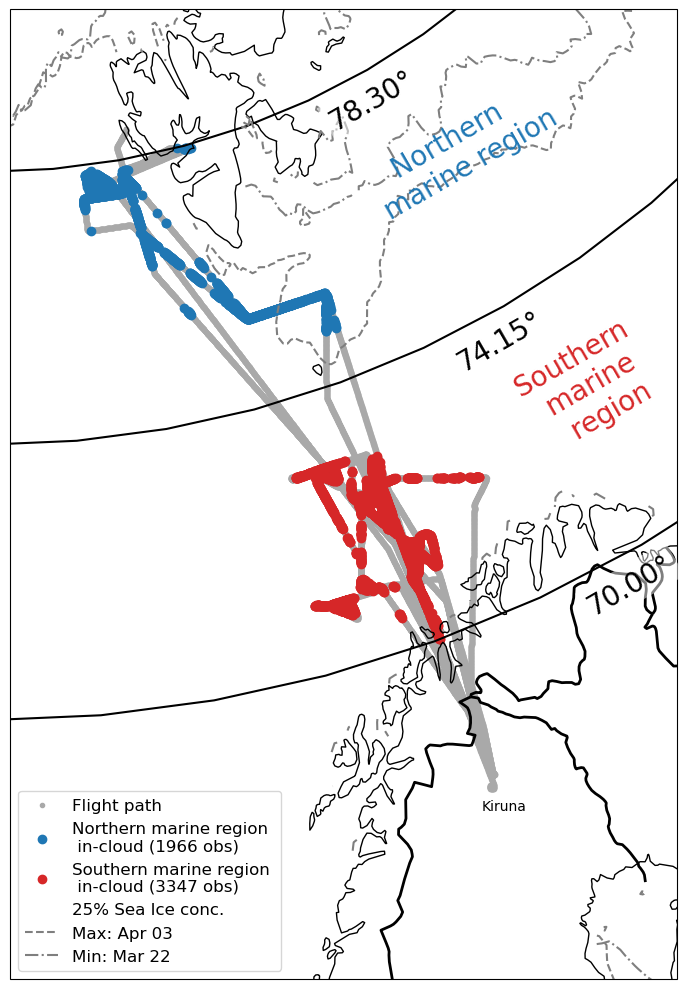

In [52]:
# --- Split for southern marine, northern marine datasets (in cloud)

# --- plotting division areas
# Define latitudes to set as boundaries
lat_min = ds_incloud.lat.values.min() 
lat_max = ds_incloud.lat.values.max()
lat_mid = lat_min + ((lat_max-lat_min)/2) # separation point for the southern marine and northern marine

# set lat-bands to compute between (as an array)
lat_bands = [lat_min, lat_mid, lat_max]

# Get the mask to use to select northern and southern band data
lat_mask_north, lat_mask_south,set_val_count_dict = plots.lat_2band_select(lat_bands, ds_incloud)

# set the value of region based on the two masks
ds_incloud['region'] = xr.where(lat_mask_north, 'north', xr.where(lat_mask_south, 'south', 'none'))

# drop values where region is 'none'
no_region_mask = (ds_incloud['region']=='none').compute()
ds_incloud = ds_incloud.where(~no_region_mask, drop=True)

# plot this variant of latitude bands:
#plot_text = f'In-cloud observations \n (tot. {len(ds_incloud.time)} obs.) per region' #\n \
           # Preselection: {pre_text}\n \
            #in-cloud threshold method: {th_method}, threshold(s): {th}'
savefile = save_path + f'Latitude_bands_regions_{sample_rate}s_{th_method}{preopt}.png'
plot_lat_bands(lat_bands, ds, ds_incloud, sic_max_ds,sic_min_ds,'', savefile= savefile)

print(savefile)


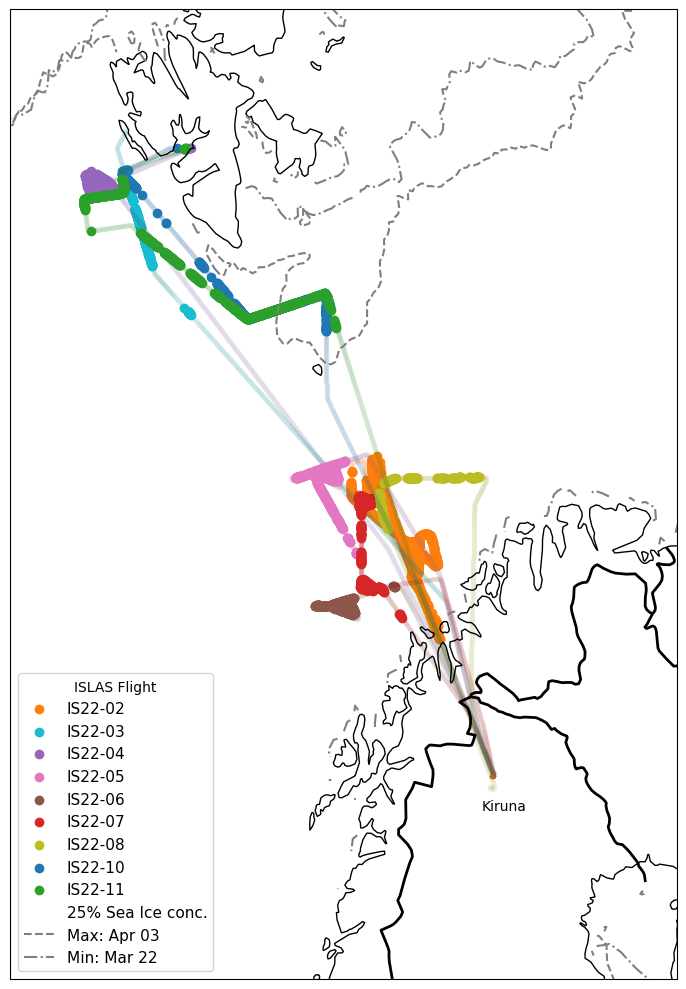

In [53]:
# Plot: incloud observations per flight

#savefile = save_path + f'Incloud_pr_flight_{min_date}.png' # testing different sea ice oconcentration files
savefile = save_path + f'Incloud_pr_flight_{sample_rate}s_{th_method}{preopt}.png'


plot_flight_obs(ds, ds_incloud,sic_max_ds, sic_min_ds, obs=True,savefile=savefile)

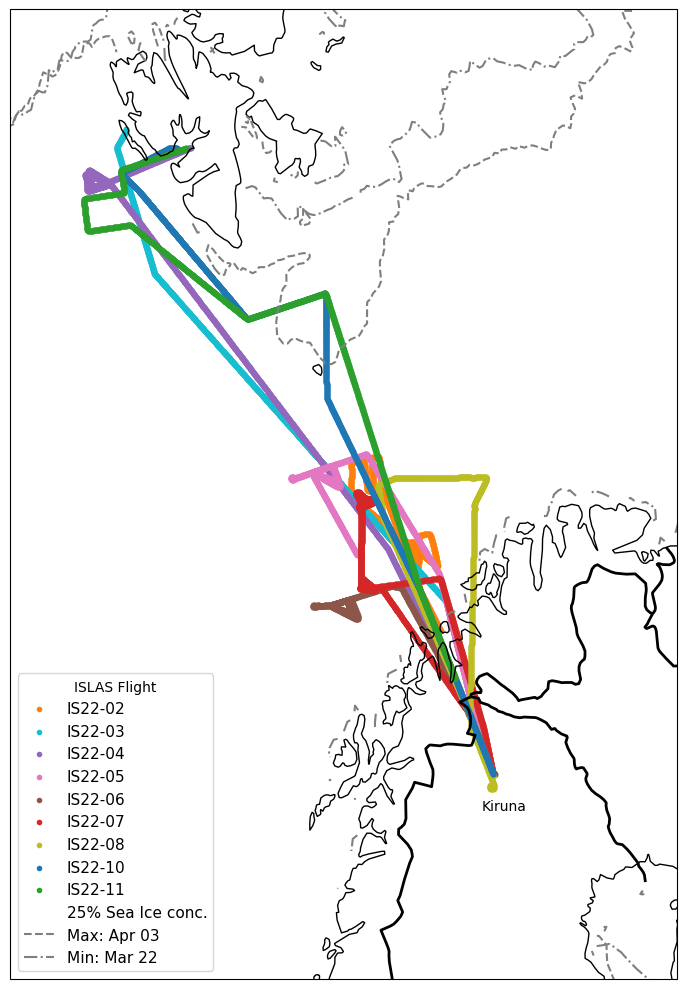

In [54]:
# Plot: flights from ISLAS campaign in use with sea ice concentration
savefile = save_path + f'Islas_flights_{sample_rate}s_{th_method}{preopt}.png'
plot_flight_obs(ds, ds_incloud,sic_max_ds, sic_min_ds, obs=False,savefile=savefile)

### Number concentration per region and per altitude band


In [55]:
# separate Northern and Southern Marine data
# - Northern marine
north_ds = ds_incloud.where(ds_incloud['region']=='north', drop = True)

# - Southern marine
south_ds = ds_incloud.where(ds_incloud['region']=='south', drop = True)



In [56]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs latitude bin
# Old version

# lat_bands: holds the division lines between lat bands: min, middle, max (floats) 
#lat_bins = np.arange(math.floor(lat_bands[0]), math.ceil(lat_bands[2])+1) # array of 1 deg lats from 70 to 79 (ints) 


#count_df = create_counts(ds_incloud, lat_bins) # counts for incloud
#count_rel_df = create_counts(ds_relevant, lat_bins) # counts for all non-cirrus data
# Calculating the percentage of total observations per category that is in cloud:
#dist_df = ((count_df/count_rel_df)*100)

# check dfs:
#print(count_df)
#print(count_rel_df)
#print(dist_df)

In [63]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs. distance bin

def reorg_heatmap_df(data):
     # reorganize data before plotting heatmap
    # - turn into dataframe - unstack to get correct array structure  
    new_df = data.to_dataframe().unstack()
    
    # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
    new_df = new_df.T.reset_index(level=0, drop = True)
    # -  make sure all possible altitude bins are represented, fill with 0 - reverse order of altitudes
    new_df = new_df.reindex(bin_labels, fill_value=0).iloc[::-1] #
    new_df = new_df.fillna(0) # set nan to 0 (for easier plot management)
    new_df = new_df.astype(int) # set the count to int

    return new_df

def create_counts_dist(ds, all=True):
    # counts of observations
    grouped_data = ds['base_time'].groupby('dist_bin')
    count_data = grouped_data.map(lambda group: group.groupby('altitude_bin').count())
    count_df = reorg_heatmap_df(count_data)

    #create mask where count is 0 (for calculating other dfs
    condition = count_df == 0

    if all:
        # mean of temperature
        temp_data = ds['T'].groupby('dist_bin')
        temp_mean_data = temp_data.map(lambda group: group.groupby('altitude_bin').mean())
        temp_mean_df = reorg_heatmap_df(temp_mean_data)
        temp_mean_df = temp_mean_df.mask(condition,np.nan) # mask the values that are not in lcoud

        #std of temperature
        temp_std_data = temp_data.map(lambda group: group.groupby('altitude_bin').std())
        temp_std_df = reorg_heatmap_df(temp_std_data)
        temp_std_df = temp_std_df.mask(condition,np.nan)

        # mean of SLF
        slf_data = ds['SLF'].groupby('dist_bin')
        slf_mean_data =slf_data.map(lambda group: group.groupby('altitude_bin').mean())
        slf_mean_df = reorg_heatmap_df(slf_mean_data)
        slf_mean_df = slf_mean_df.mask(condition,np.nan)

        slf_std_data =slf_data.map(lambda group: group.groupby('altitude_bin').std())
        slf_std_df = reorg_heatmap_df(slf_std_data)
        slf_std_df = slf_std_df.mask(condition,np.nan)

        # count of flights per box
        id_df = ds['islasid'].to_dataframe()
        grouped_df = id_df.groupby('dist_bin')  # Groupby dist_bin
        id_count_df = grouped_df.apply(lambda group: group.groupby('altitude_bin')['islasid'].nunique()).iloc[:,0]
        id_count_df = id_count_df.unstack()
        # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
        id_count_df = id_count_df.T
        # flip axis
        id_count_df = id_count_df.iloc[::-1] #

        # median size (droplet/cdo/ED and crystal/CIP/MVD100)
        cdp_size_data = ds['ED'].groupby('dist_bin')
        cdp_size_mean_data = cdp_size_data.map(lambda group: group.groupby('altitude_bin').mean())
        cdp_size_mean_df = reorg_heatmap_df(cdp_size_mean_data)
        cdp_size_mean_df = cdp_size_mean_df.mask(condition,np.nan)

        cdp_size_std_data = cdp_size_data.map(lambda group: group.groupby('altitude_bin').std())
        cdp_size_std_df = reorg_heatmap_df(cdp_size_std_data)
        cdp_size_std_df = cdp_size_std_df.mask(condition,np.nan)

        cip_size_data = ds['MVD100'].groupby('dist_bin')
        cip_size_mean_data = cip_size_data.map(lambda group: group.groupby('altitude_bin').mean())
        cip_size_mean_df = reorg_heatmap_df(cip_size_mean_data)
        cip_size_mean_df = cip_size_mean_df.mask(condition,np.nan)

        cip_size_std_data = cip_size_data.map(lambda group: group.groupby('altitude_bin').std())
        cip_size_std_df = reorg_heatmap_df(cip_size_std_data)
        cip_size_std_df = cip_size_std_df.mask(condition,np.nan)

        # mean number concentration (droplet/cdp/Number conc corr. and crystal/CIP/NT)
        cdp_n_data = ds['Number Conc corr'].groupby('dist_bin')
        cdp_n_mean_data = cdp_n_data.map(lambda group: group.groupby('altitude_bin').mean())
        cdp_n_mean_df = reorg_heatmap_df(cdp_n_mean_data)
        cdp_n_mean_df = cdp_n_mean_df.mask(condition,np.nan)

        cdp_n_std_data = cdp_n_data.map(lambda group: group.groupby('altitude_bin').std())
        cdp_n_std_df = reorg_heatmap_df(cdp_n_std_data)
        cdp_n_std_df = cdp_n_std_df.mask(condition,np.nan)

        cip_n_data = ds['NT'].groupby('dist_bin')
        cip_n_mean_data = cip_n_data.map(lambda group: group.groupby('altitude_bin').mean())
        cip_n_mean_df = reorg_heatmap_df(cip_n_mean_data)
        cip_n_mean_df = cip_n_mean_df.mask(condition,np.nan)

        cip_n_std_data = cip_n_data.map(lambda group: group.groupby('altitude_bin').std())
        cip_n_std_df = reorg_heatmap_df(cip_n_std_data)
        cip_n_std_df = cip_n_std_df.mask(condition,np.nan)

        return count_df, temp_mean_df, temp_std_df, slf_mean_df, slf_std_df, id_count_df,cdp_size_mean_df,cdp_size_std_df,cip_size_mean_df,cip_size_std_df,cdp_n_mean_df,cdp_n_std_df,cip_n_mean_df,cip_n_std_df
    else:
        return count_df


count_df, temp_mean_df, temp_std_df, slf_mean_df, slf_std_df,id_count_df,cdp_size_mean_df,cdp_size_std_df,cip_size_mean_df,cip_size_std_df,cdp_n_mean_df,cdp_n_std_df,cip_n_mean_df,cip_n_std_df = create_counts_dist(ds_incloud) # counts for incloud
count_rel_df = create_counts_dist(ds_relevant, all=False) # counts for all non-cirrus data
# Calculating the percentage of total observations per category that is in cloud:
dist_df = ((count_df/count_rel_df)*100)


/tmp/ipykernel_45674/3972572699.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  id_count_df = grouped_df.apply(lambda group: group.groupby('altitude_bin')['islasid'].nunique()).iloc[:,0]


/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/Perc_incloud_alt_sic-dist125_5s.png


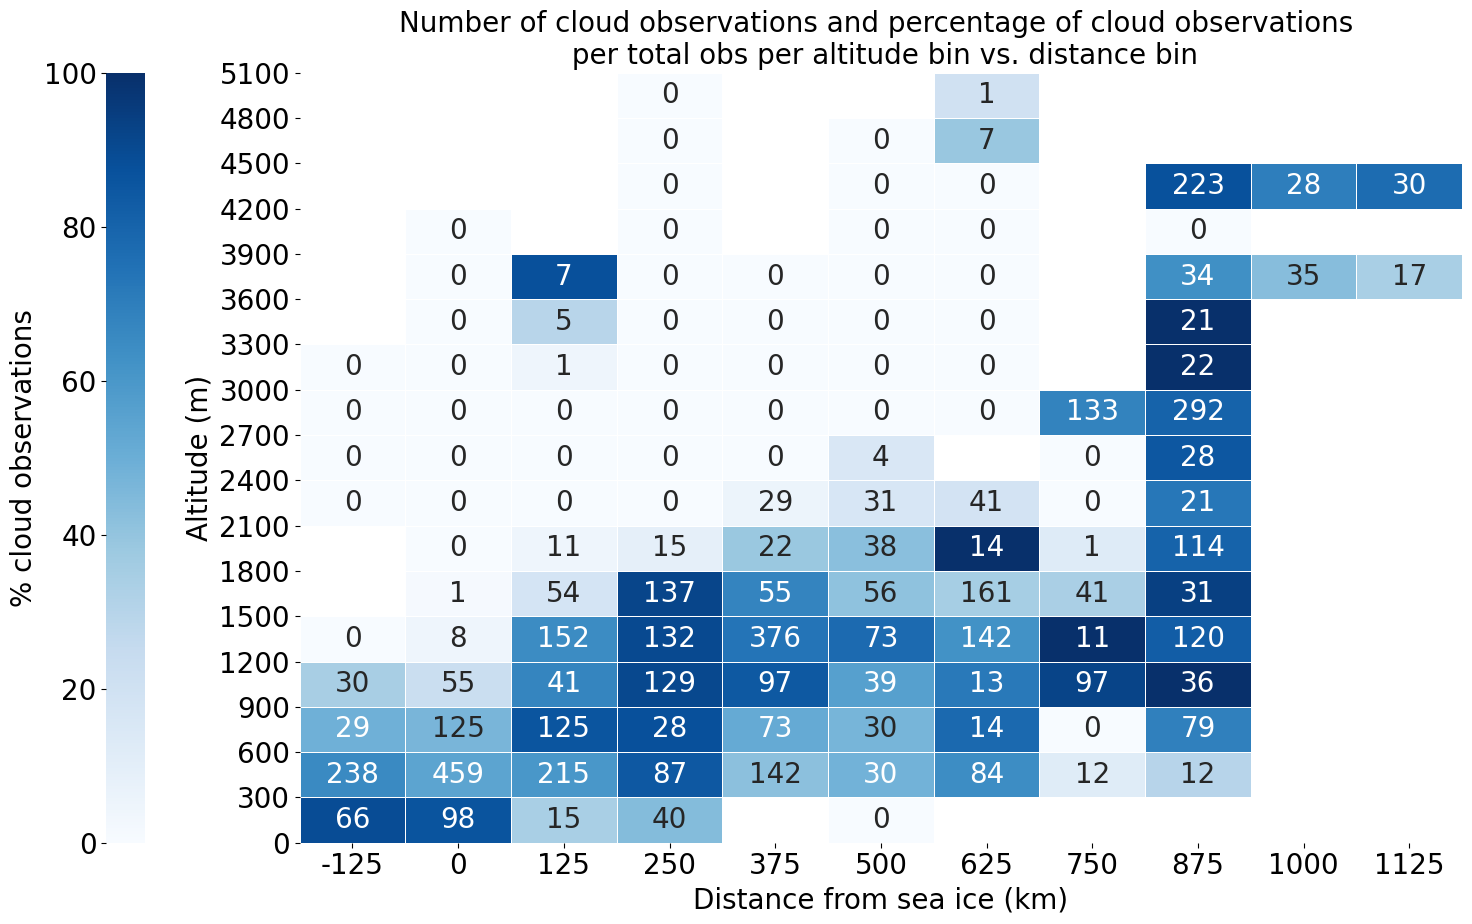

In [36]:
# Version 1: heatplot of percentage of observations that where in-cloud
# Without temperature

f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

pl = sns.heatmap(dist_df, annot=count_df, fmt=".0f", cmap='Blues', ax=ax, 
            cbar_kws={"label": "% cloud observations", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)

#pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss) #when using latitude
pl.set_xlabel('Distance from sea ice (km)', fontsize=ss) # when using distance
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('% cloud observations', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=45)

# add overlines (only when using latitude)
# Create overlay plot
ax_lines = f.add_axes(ax.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)


# Plot the limit between the two regions
#ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
#ax_lines.text(lat_bands[1] + 4, 4600, 'Northern marine region', c='b', weight='bold', fontsize=hs)
#ax_lines.text(lat_bands[1] - 0.6, 4600, 'Southern marine region', c='r', weight='bold', fontsize=hs)
#ax_lines.text(lat_bands[1] + 0.75, 3900, f"{lat_bands[1]:.2f}°", weight='bold',c='k', fontsize=ss)

#plt.title(f'Percentage of in cloud observations per total obs per altitute_bin vs. lat_bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}')
plt.title(f'Number of cloud observations and percentage of cloud observations \n per total obs per altitude bin vs. distance bin', fontsize=20)
plt.savefig(save_path + f'Perc_incloud_alt_sic-dist_{sample_rate}.png', bbox_inches='tight')

#print(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}.png')
print(save_path + f'Perc_incloud_alt_sic-dist125_{sample_rate}s.png')

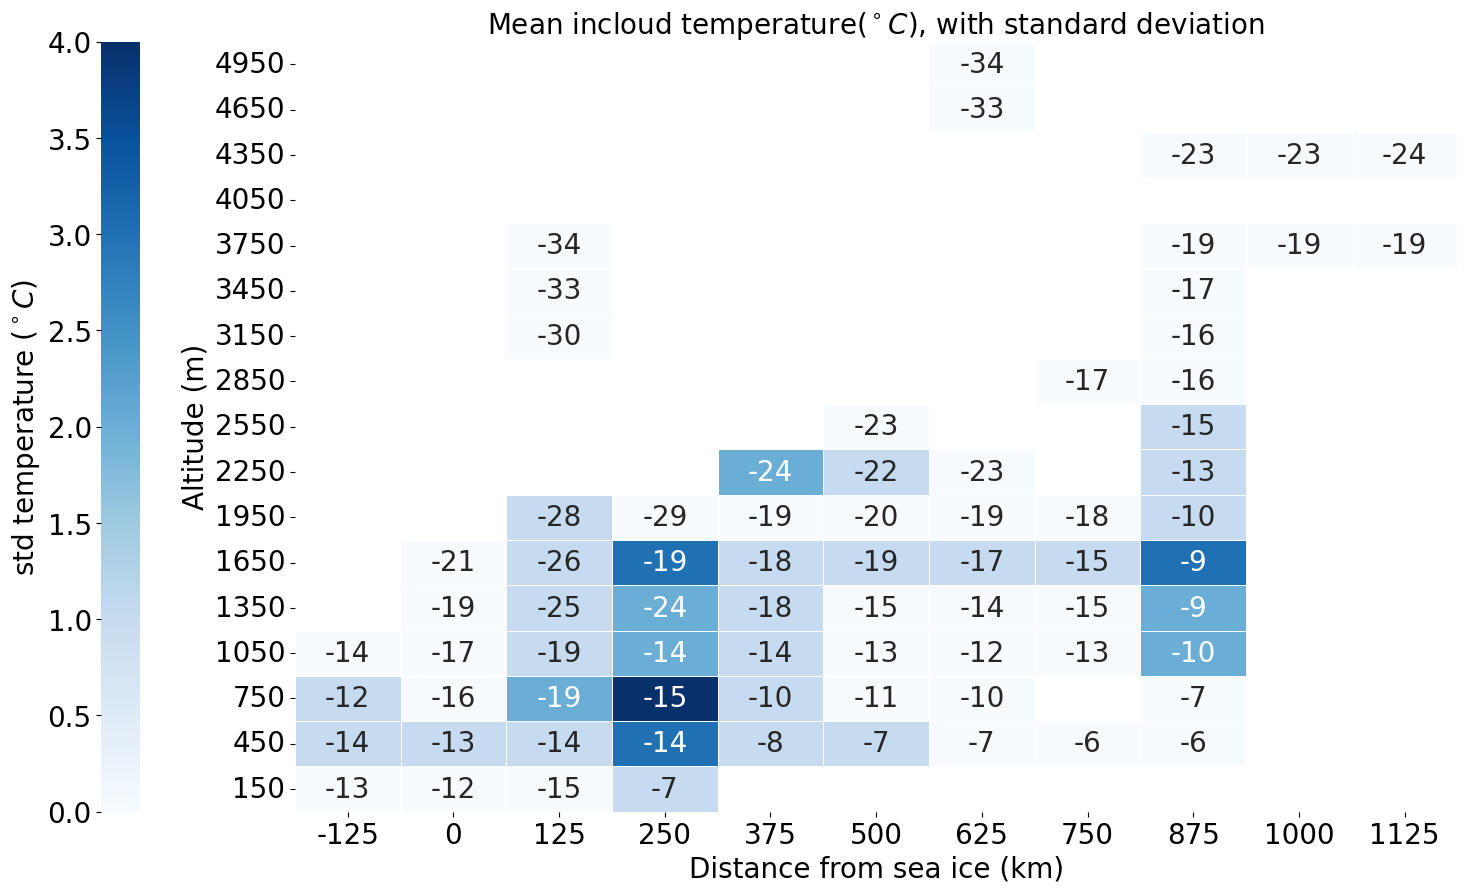

In [26]:
# Version 1: heatplot of mean temperature in-cloud
#temp_mean_df, temp_std_df,

f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

# mask nan values for annotation
nan_mask = temp_mean_df.isna()


pl = sns.heatmap(temp_std_df, annot=temp_mean_df, fmt=".0f", cmap='Blues', mask=nan_mask, ax=ax, 
            cbar_kws={"label": "std temperature ($^\circ C$)", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)


pl.set_xlabel('Distance from sea ice (km)', fontsize=ss) # when using distance
pl.set_ylabel('Altitude (m)', fontsize=ss)
#pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('std temperature ($^\circ C$)', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss)

plt.title(f'Mean incloud temperature($^\circ C$), with standard deviation', fontsize=20)
plt.savefig(save_path + f'temp_incloud_alt_dist125_{sample_rate}s.png', bbox_inches='tight')


Text(0.5, 1.0, 'Mean incloud SLF, with standard deviation')

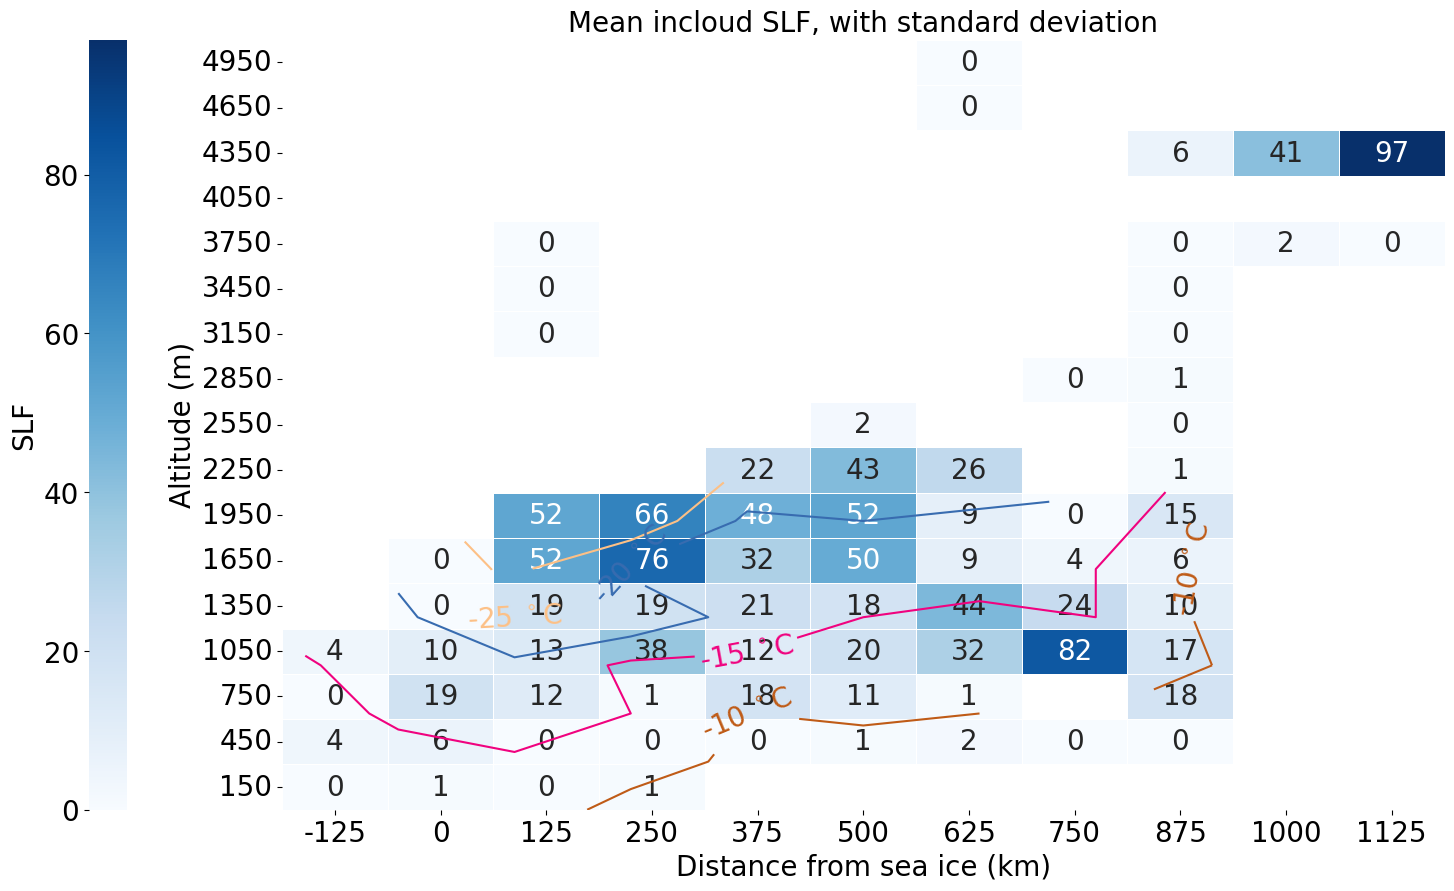

In [38]:
# Version 1: heatplot of mean SLF in-cloud
#slf_mean_df

f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

# mask nan values for annotation
nan_mask = slf_mean_df.isna()

# Prepare temperature observations for contour plot
X,Y = np.meshgrid(temp_mean_df.columns, temp_mean_df.index)
Z = temp_mean_df.values

pl = sns.heatmap(slf_mean_df, annot=True, fmt=".0f", cmap='Blues', mask=nan_mask, ax=ax, 
            cbar_kws={"label": "SLF", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)

ax_t = f.add_axes(pl.get_position(), frameon=False)
temp_c = ax_t.contour(X, Y, Z, levels=5, cmap='Accent')

def fmt(x):
    # function to add temp unit
    s = f"{x:.0f}"
    return f"{s} $^\circ$C"

ax.clabel(temp_c, temp_c.levels, fmt=fmt, fontsize=ss)

#ax_t.set_xlim(-150,1170)
#ax_t.set_ylim(0,4500)
#ax_t.set_yticks(altitude_bins)
ax_t.axes.get_xaxis().set_visible(False)
ax_t.axes.get_yaxis().set_visible(False)

pl.set_xlabel('Distance from sea ice (km)', fontsize=ss) # when using distance
pl.set_ylabel('Altitude (m)', fontsize=ss)
#pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('SLF', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss)

plt.title(f'Mean incloud SLF, with standard deviation', fontsize=20)
#plt.savefig(save_path + f'slf_incloud_TC_alt_dist125_{sample_rate}s.png', bbox_inches='tight')

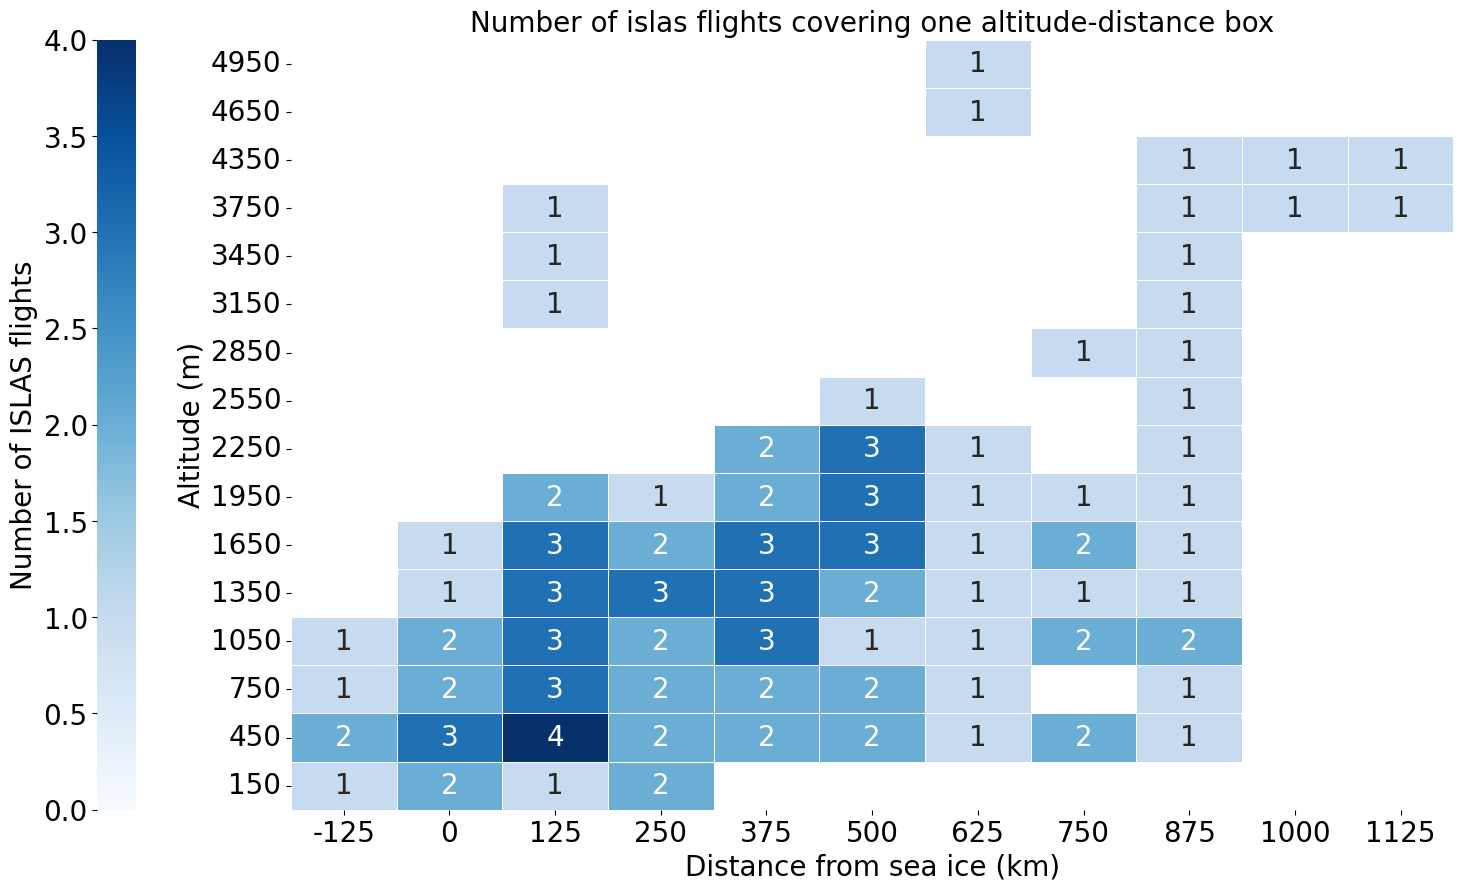

In [90]:
# Figure for suplementary materials: Number of flights in each altitude-distance bin

f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

# mask nan values for annotation
nan_mask = id_count_df.isna()

pl = sns.heatmap(id_count_df, annot=True, fmt=".0f", cmap='Blues', mask=nan_mask, ax=ax, 
            cbar_kws={"label": "Number of ISLAS flights", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)


pl.set_xlabel('Distance from sea ice (km)', fontsize=ss) # when using distance
pl.set_ylabel('Altitude (m)', fontsize=ss)

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('Number of ISLAS flights', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=0)

plt.title(f'Number of islas flights covering one altitude-distance box', fontsize=20)
plt.savefig(save_path + f'islasid_alt_dist125_{sample_rate}s.png', bbox_inches='tight')


Text(0.5, 1.0, 'Mean droplet size ($\\mu$m) per altitude-distance box')

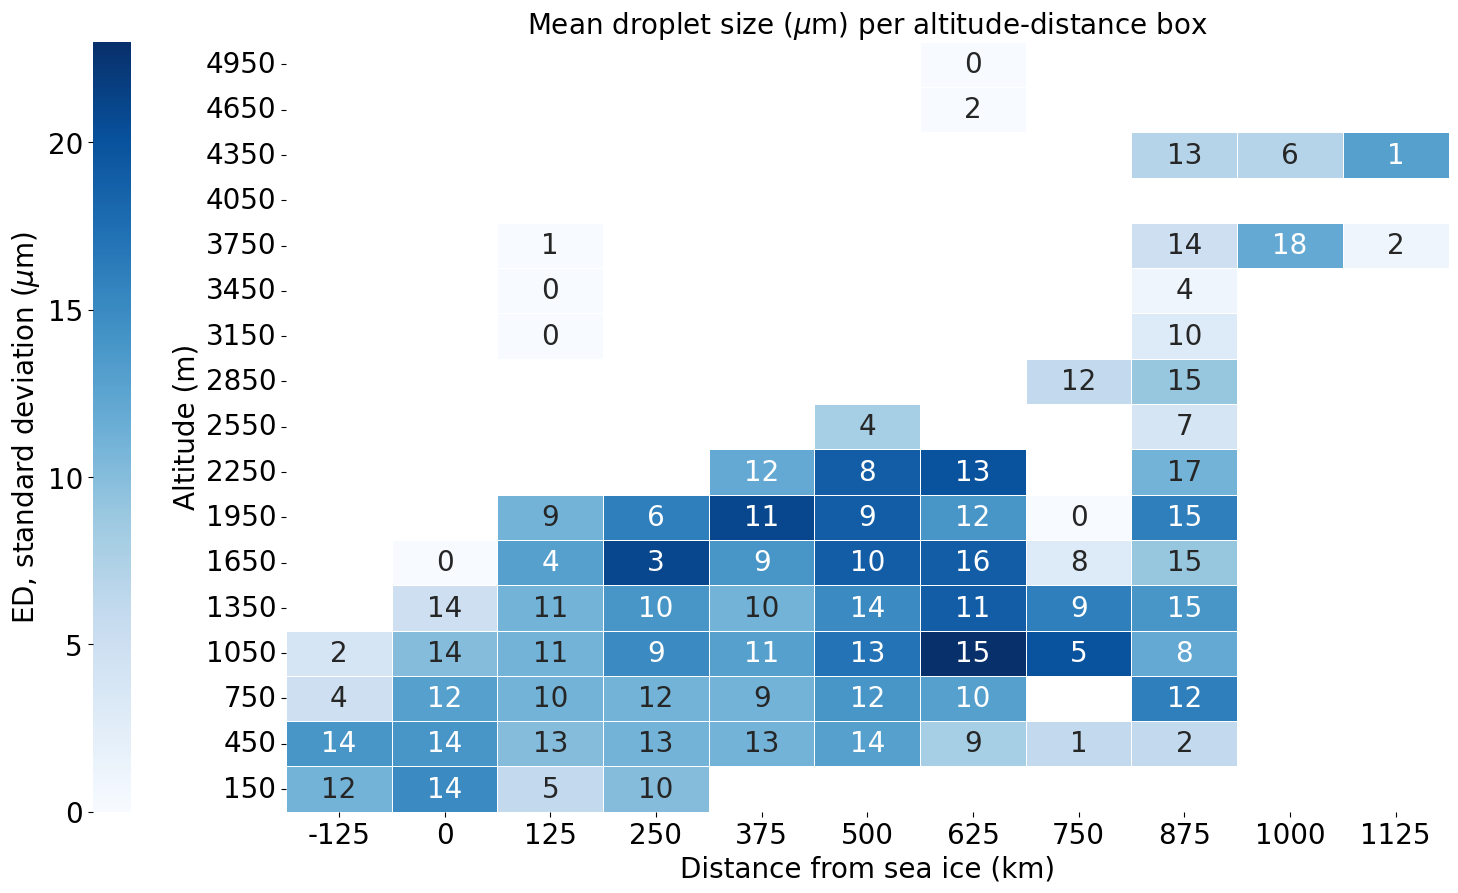

In [71]:
# Figure for suplementary materials: CDP droplet size
#ds_incloud['ED'].attrs['unit'] #unit

f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

# mask nan values for annotation
nan_mask = cdp_size_mean_df.isna()

pl = sns.heatmap(cdp_size_mean_df, annot=cdp_size_std_df, fmt=".0f", cmap='Blues', mask=nan_mask, ax=ax, 
            cbar_kws={"label": "Mean droplet size", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)


pl.set_xlabel('Distance from sea ice (km)', fontsize=ss) # when using distance
pl.set_ylabel('Altitude (m)', fontsize=ss)

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label(f'ED, standard deviation ($\mu$m)', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=0)

plt.title(f'Mean droplet size ($\mu$m) per altitude-distance box', fontsize=20)
#plt.savefig(save_path + f'islasid_alt_dist125_{sample_rate}s.png', bbox_inches='tight')

um


Text(0.5, 1.0, 'Mean droplet size ($\\mu$m) per altitude-distance box')

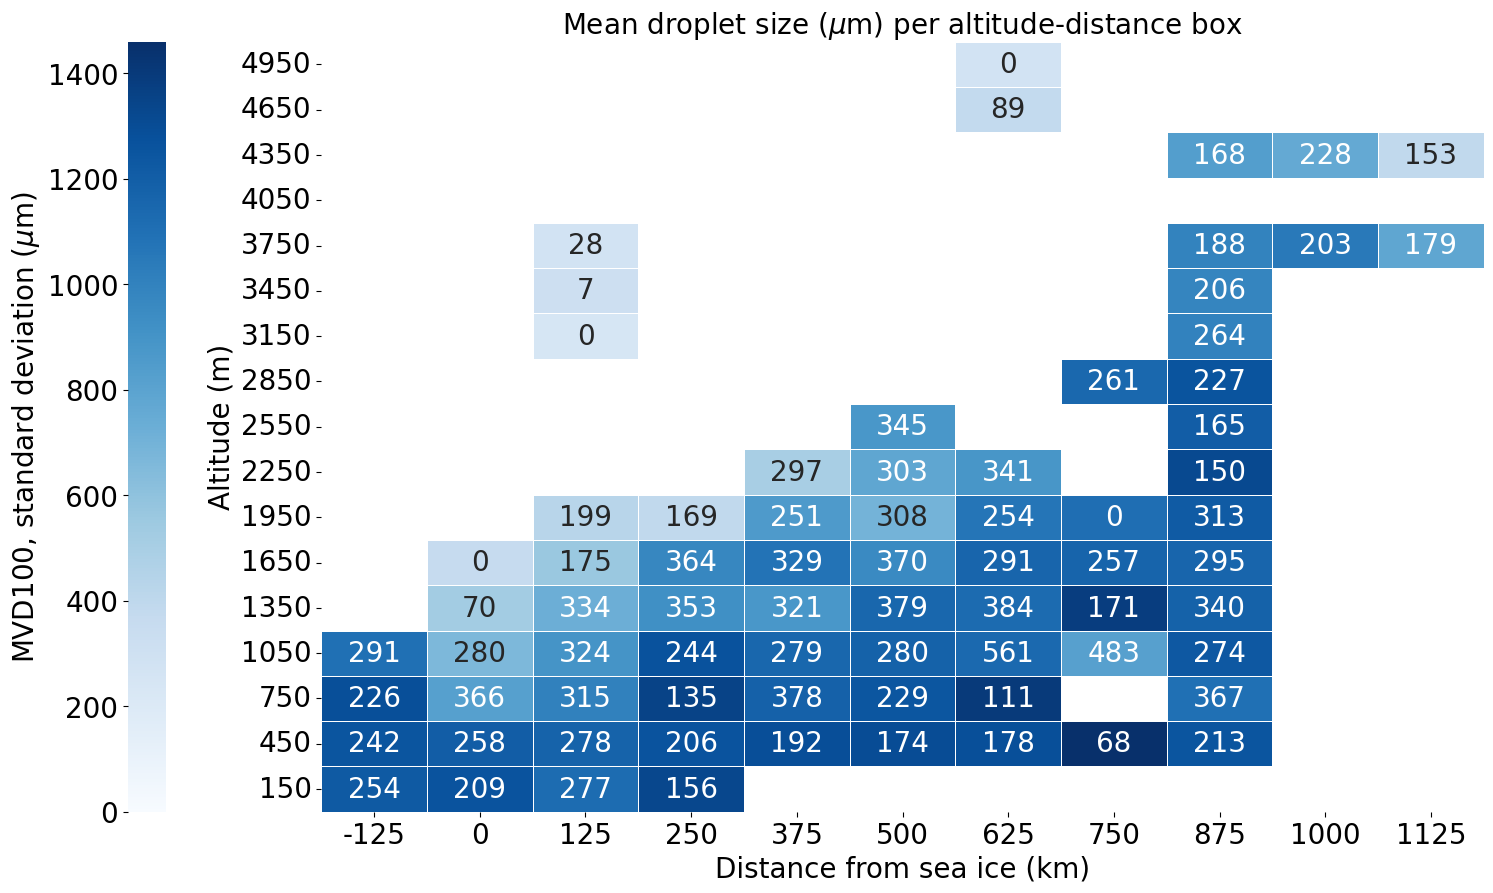

In [ ]:

# Figure for suplementary materials: Ice crystal size


f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

# mask nan values for annotation
nan_mask = cip_size_mean_df.isna()

pl = sns.heatmap(cip_size_mean_df, annot=cip_size_std_df, fmt=".0f", cmap='Blues', mask=nan_mask, ax=ax, 
            cbar_kws={"label": "Mean ice crystal size", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)


pl.set_xlabel('Distance from sea ice (km)', fontsize=ss) # when using distance
pl.set_ylabel('Altitude (m)', fontsize=ss)

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label(f'MVD100, standard deviation ($\mu$m)', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=0)

plt.title(f'Mean droplet size ($\mu$m) per altitude-distance box', fontsize=20)
#plt.savefig(save_path + f'islasid_alt_dist125_{sample_rate}s.png', bbox_inches='tight')

Text(0.5, 1.0, 'Mean droplet number concentration per altitude-distance box')

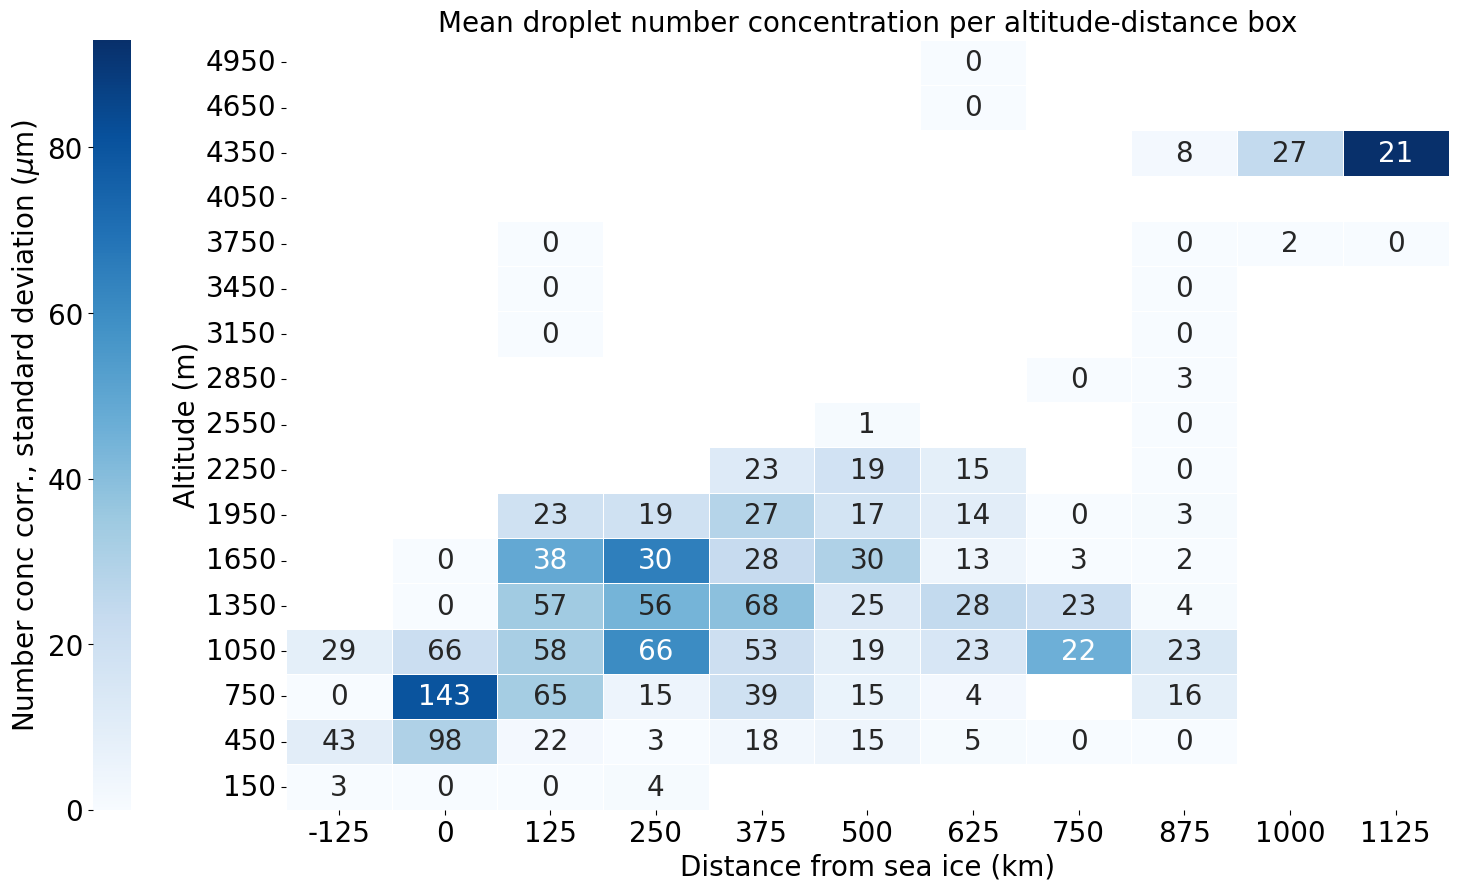

In [ ]:

# Figure for suplementary materials: droplet number concentraiton
# cip_n_mean_df,cip_n_std_df

f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

# mask nan values for annotation
nan_mask = cdp_n_mean_df.isna()

pl = sns.heatmap(cdp_n_mean_df, annot=cdp_n_std_df, fmt=".0f", cmap='Blues', mask=nan_mask, ax=ax, 
            cbar_kws={"label": "mean droplet number concentration", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)


pl.set_xlabel('Distance from sea ice (km)', fontsize=ss) # when using distance
pl.set_ylabel('Altitude (m)', fontsize=ss)

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label(f'Number conc corr., standard deviation ($\mu$m)', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=0)

plt.title(f'Mean droplet number concentration per altitude-distance box', fontsize=20)
#plt.savefig(save_path + f'islasid_alt_dist125_{sample_rate}s.png', bbox_inches='tight')

Text(0.5, 1.0, 'Mean ice crystal number concentration per altitude-distance box')

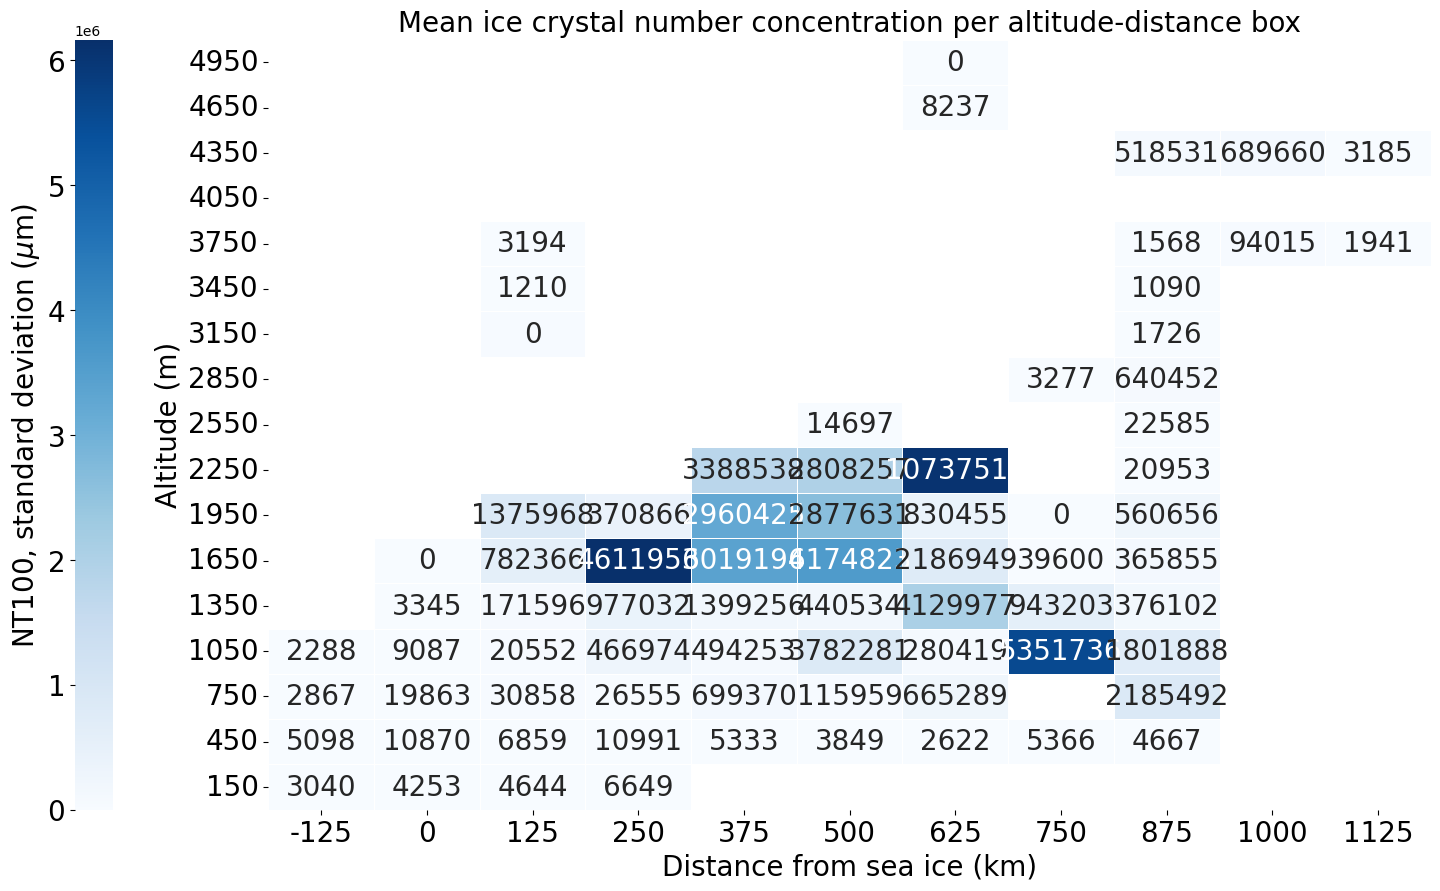

In [75]:

# Figure for suplementary materials: ice crystal number concentraiton
# cip_n_mean_df,cip_n_std_df

f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

# mask nan values for annotation
nan_mask = cip_n_mean_df.isna()

pl = sns.heatmap(cip_n_mean_df, annot=cip_n_std_df, fmt=".0f", cmap='Blues', mask=nan_mask, ax=ax, 
            cbar_kws={"label": "mean ice crystal number concentration", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)


pl.set_xlabel('Distance from sea ice (km)', fontsize=ss) # when using distance
pl.set_ylabel('Altitude (m)', fontsize=ss)

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label(f'NT100, standard deviation ($\mu$m)', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=0)

plt.title(f'Mean ice crystal number concentration per altitude-distance box', fontsize=20)
#plt.savefig(save_path + f'islasid_alt_dist125_{sample_rate}s.png', bbox_inches='tight')

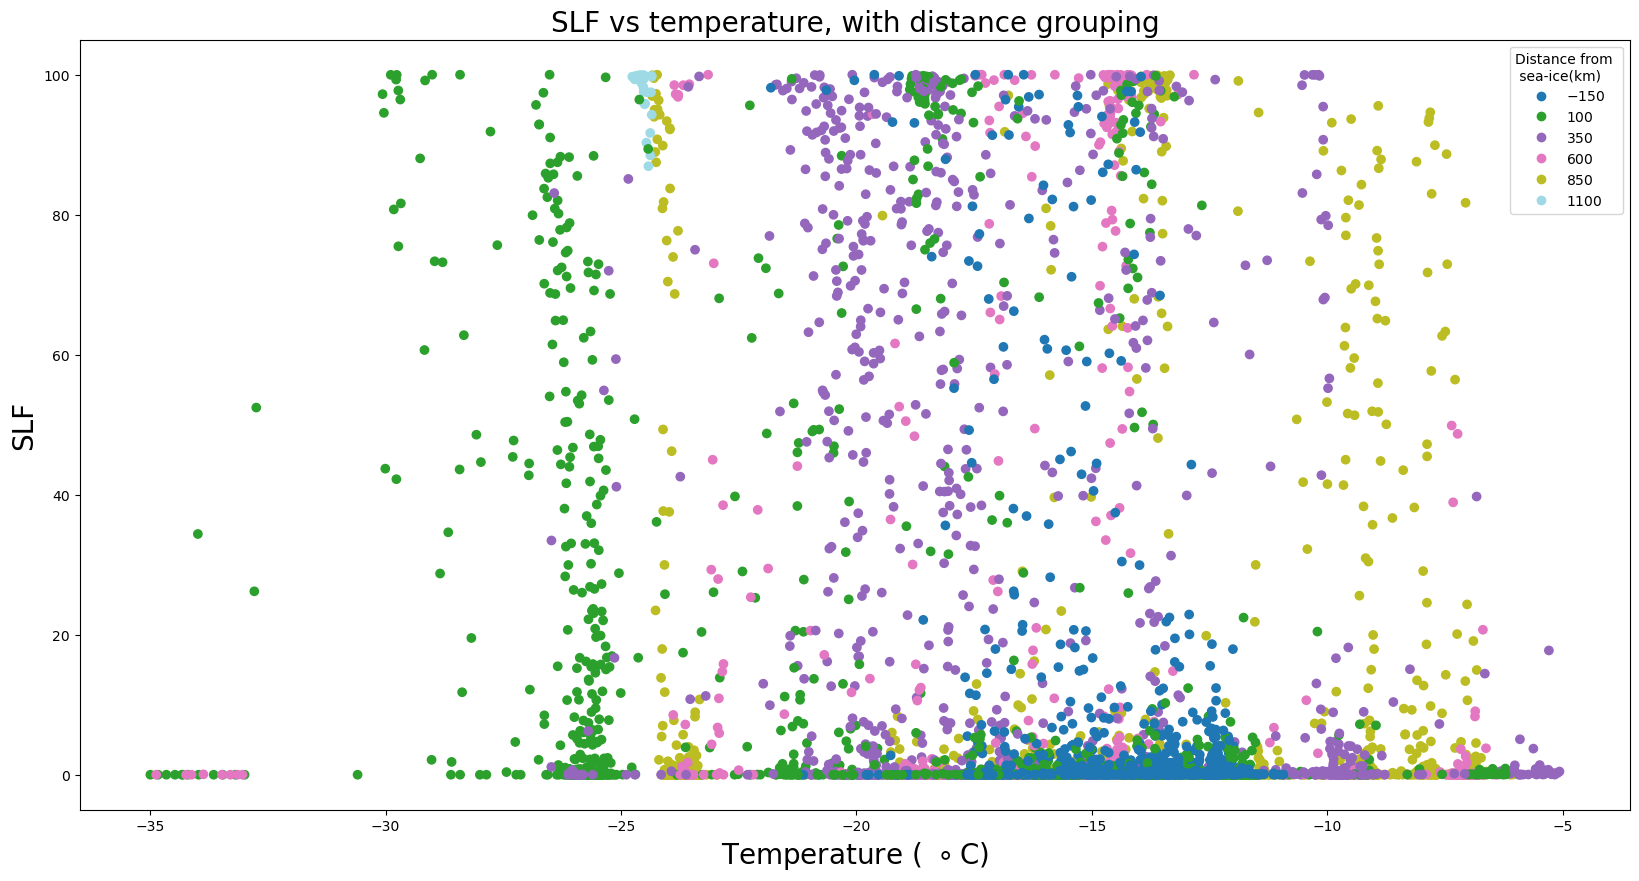

In [28]:
f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

pl = ax.scatter(ds_incloud['T'].values, ds_incloud['SLF'].values, c=ds_incloud['dist_bin'], cmap='tab20')
    
ax.legend(*pl.legend_elements(), loc='upper right', title='Distance from \n sea-ice(km)')

ax.set_xlabel('Temperature ($~\circ$C)', fontsize=ss) # when using distance
ax.set_ylabel('SLF', fontsize=ss)


# ticklabel adjustments
#xlab = pl.get_xticklabels() 
#pl.set_xticklabels(labels = xlab, size=ss)
#ylab = pl.get_yticklabels()
#for label in ylab:
#    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
#pl.set_yticklabels(labels = ylab, size = ss)

plt.title(f'SLF vs temperature, with distance grouping', fontsize=20)
plt.savefig(save_path + f'slf_incloud_temp_distgroup250_{sample_rate}s.png', bbox_inches='tight')

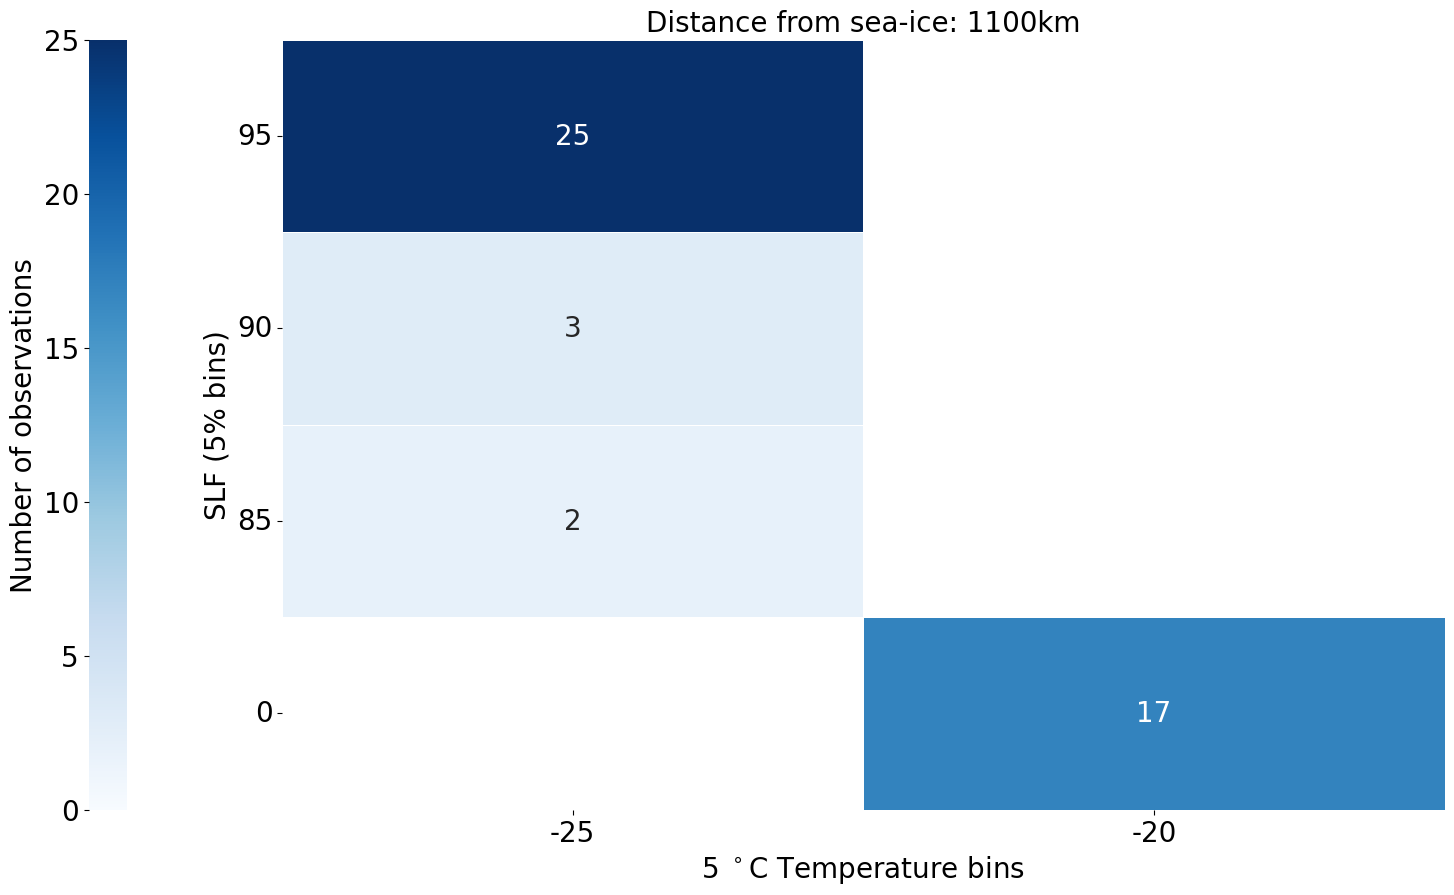

In [76]:
# heatmaps per distance bin

# - make 1 plot per distance bin. for 250 km distance bins that is 6 plots
# - each heatmap should be slf vs temperature (so the "count_df"s needs to be calculated over ds_incloud filtered by distance bin)

# get the list of distance bins
dists = np.unique(ds_incloud['dist_bin'].values)

# filter ds_incloud on first dists
i=5
dist_mask = (ds_incloud['dist_bin']==dists[i]).compute()
ds_dist = ds_incloud.where(dist_mask, drop = True)

# Group by SLF: 5% and temperature 4 degrees and create df for heatmap
grouped_slf_data = ds_dist['base_time'].groupby('slf_bin')
count_slf_data = grouped_slf_data.map(lambda group: group.groupby('temp_bin').count())
# reorganize data before plotting heatmap
# - turn into dataframe 
count_slf_df = pd.DataFrame(count_slf_data.values) # get only the values (to avoid base_time)
row_n = count_slf_data.slf_bin.values # get slfbin values for index
count_slf_df = count_slf_df.set_axis(row_n,axis=0)
column_n = count_slf_data.temp_bin.values # get temp bin values for columns
count_slf_df = count_slf_df.set_axis(column_n,axis=1)


count_slf_df = count_slf_df.iloc[::-1] # flip y-axis
#print(count_slf_df)


f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

pl = sns.heatmap(count_slf_df, annot=True, fmt=".0f", cmap='Blues', ax=ax, 
            cbar_kws={"label": "SLF", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)


pl.set_xlabel('5 $^\circ$C Temperature bins', fontsize=ss) # when using distance
pl.set_ylabel('SLF (5% bins)', fontsize=ss)


# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('Number of observations', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
#for label in ylab:
#    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=0)

plt.title(f'Distance from sea-ice: {dists[i]}km', fontsize=20)
plt.savefig(save_path + f'slf_incloud_temp_distcat{dists[i]}_{sample_rate}s.png', bbox_inches='tight')


In [56]:
count_slf_data.temp_bin.values

array([-25, -20, -15])

(0.0, 5100.0)

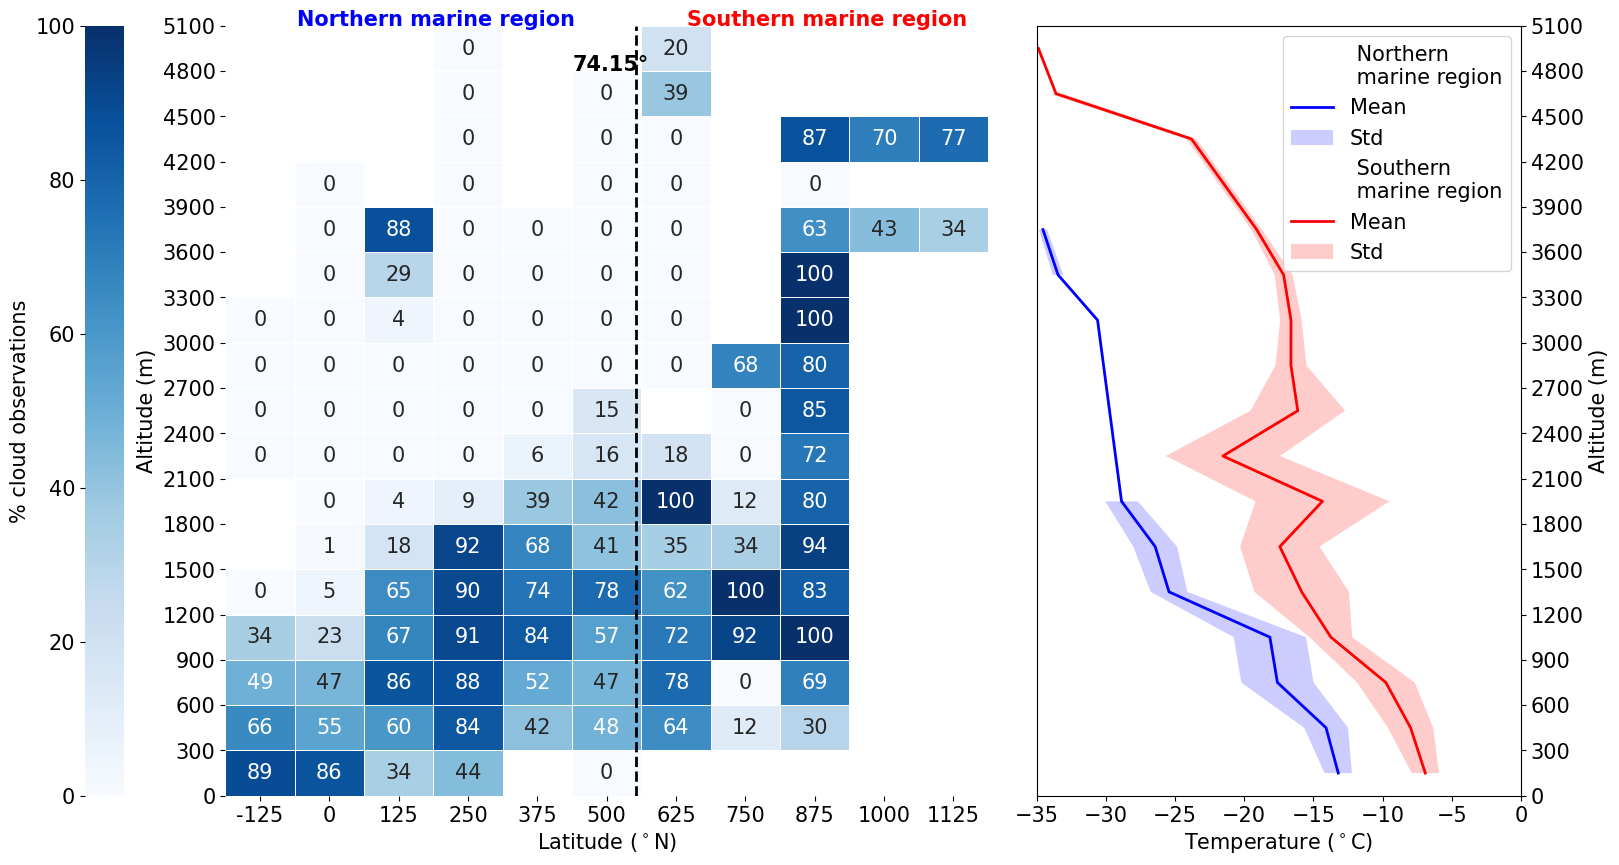

In [176]:
# Version 2: heatplot of percentage of observations that where in-cloud
# With temperature


# Set up the figure with Gridspec
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3, wspace=0.1)  # 1 row, 3 columns

# Create the heatmap on the left (2/3 of the width)
ax_heatmap = fig.add_subplot(gs[:, :2])

#plot text size options
hs=15
ss=15


pl = sns.heatmap(dist_df, annot=True, fmt=".0f", cmap='Blues', ax=ax_heatmap, 
            cbar_kws={"label": "% cloud observations", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)

pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('% cloud observations', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=45)

# add overlines
# Create overlay plot
ax_lines = fig.add_axes(pl.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)


# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] + 4, 5100, 'Northern marine region', c='b', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] - 0.6, 5100, 'Southern marine region', c='r', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] + 0.75, 4800, f"{lat_bands[1]:.2f}°", weight='bold',c='k', fontsize=ss)

ax_temp = fig.add_subplot(gs[:,2])

# Temperature southern and northern marine
# -- southern marine: mean and std
# Select variables to plot
sel_vars = ['altitude_bin', 'T']

south_df = south_ds[sel_vars].to_dataframe().reset_index()
s_t_mean = south_df.groupby('altitude_bin')['T'].mean()
s_t_std = south_df.groupby('altitude_bin')['T'].std()

# -- northern marine: mean and std
north_df = north_ds[sel_vars].to_dataframe().reset_index()
n_t_mean = north_df.groupby('altitude_bin')['T'].mean()
n_t_std = north_df.groupby('altitude_bin')['T'].std()

# the comma is to get the first element of the list returned
nmn, = ax_temp.plot(n_t_mean, n_t_mean.index, label = 'Northern \n marine region \n mean', lw=2,color = 'blue')
nstd = ax_temp.fill_betweenx(n_t_mean.index, n_t_mean+n_t_std, n_t_mean-n_t_std, facecolor='blue', alpha=0.2, label='N.M.R. std')

smn, = ax_temp.plot(s_t_mean, s_t_mean.index, label = 'Southern \n marine region \n mean', lw=2,color = 'red')
sstd = ax_temp.fill_betweenx(s_t_mean.index, s_t_mean+s_t_std, s_t_mean-s_t_std, facecolor='red', alpha=0.2, label='S.M.R. std')


# Create to title legend
legend_handles = [nmn, nstd, smn, sstd]
legend_labels = ['Mean', 'Std', 'Mean', 'Std']

# Create a legend with titles and custom handles
from matplotlib.lines import Line2D

# Create custom legend handles for the two titles
title1 = Line2D([0], [0], color='none', label=' Northern \n marine region', lw=0)  # Empty handle for title
title2 = Line2D([0], [0], color='none', label=' Southern \n marine region', lw=0)  # Empty handle for title

# Combine the handles and labels
handles = [title1] + [legend_handles[0], legend_handles[1], title2, legend_handles[2], legend_handles[3]]
labels = [title1.get_label(),legend_labels[0], legend_labels[1], title2.get_label(), legend_labels[2], legend_labels[3]]

# Add legend to the plot
ax_temp.legend(handles=handles, labels=labels, loc='upper right', fontsize=ss)

ax_temp.tick_params(axis='both', which='major', labelsize=ss)
ax_temp.set_ylabel('Altitude (m)', fontsize = ss)
ax_temp.yaxis.set_label_position("right")
ax_temp.set_xlabel('Temperature ($^\circ$C)', fontsize = ss)
ax_temp.set_xlim([-35, 0])

ax_temp.yaxis.tick_right()
ax_temp.set_yticks(altitude_bins)
ax_temp.set_ylim([0,5100])

#plt.title(f'Percentage of in cloud observations per total obs per alt_bin vs. lat_bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}')
#plt.title(f'Percentage of in cloud observations \n per total obs per alt_bin vs. lat_bin', fontsize=20)
#plt.savefig(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}.png', bbox_inches='tight')

#print(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}.png')

In [ ]:
# make the distribution plots per flight
# heatplot of percentage of observations that where in-cloud
f, axs = plt.subplots(3,3,figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

ids = np.unique(ds_incloud.islasid.values)

for islasid, ax in zip(ids, axs.ravel()):
    #filter the two main dataframes on the flight
    ds_incloud_flight = ds_incloud.where(ds_incloud['islasid']==islasid, drop = True)
    ds_relevant_flight = ds_relevant.where(ds_relevant['islasid']==islasid, drop = True)
    
    # create dataframe with the data to visualize in the separate plots:
    # lat_bins is the same as for the full dataset
    
    count_df = create_counts(ds_incloud_flight, lat_bins) # counts for incloud selection
    count_rel_df = create_counts(ds_relevant_flight, lat_bins) # counts for all observations
    # Calculating the percentage of total observations per category that is in cloud:
    dist_df = ((count_df/count_rel_df)*100)

    #plot text size options
    hs=15
    ss=10
    #i = 0
    #j = 0
    pl = sns.heatmap(dist_df, annot=True, fmt=".0f", cmap='Blues', ax=ax, 
                cbar_kws={"label": "% cloud observations"},
                linewidths=0.5, annot_kws={'size':ss}, vmin=0, vmax = 100)
    
    ax.set_title(f'{islasid} ({len(ds_incloud_flight.time)} incloud obs.)')
    
    pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
    pl.set_ylabel('Altitude (m)', fontsize=ss)
    pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

    # add overlines
    # Create overlay plot
    ax_lines = f.add_axes(ax.get_position(), frameon=False)
    ax_lines.set_xlim(79,70)
    ax_lines.set_ylim(0,4500)
    yticks = np.linspace (0,4500,300)
    ax_lines.set_yticks(altitude_bins)
    ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
    ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
    ax_lines.tick_params(labelsize=ss)

    # Plot the limit between the two regions
    ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
    #ax_lines.text(lat_bands[1] + 4.8, 0, 'Northern marine region', c='b', rotation = 90, fontsize=hs)
    #ax_lines.text(lat_bands[1] - 4.1, 0, 'Southern marine region', c='r', rotation = 90, fontsize=hs)
    ax_lines.text(lat_bands[1] + 1.5, 3900, f"{lat_bands[1]:.2f}°",c='k', fontsize=ss)

    

plt.savefig(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}_singleflights.png', bbox_inches='tight')

In [ ]:
# make the distribution plots per flight
# heatplot of number of observations that where in-cloud
f, axs = plt.subplots(3,3,figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

ids = np.unique(ds_incloud.islasid.values)

for islasid, ax in zip(ids, axs.ravel()):
    #filter the two main dataframes on the flight
    ds_incloud_flight = ds_incloud.where(ds_incloud['islasid']==islasid, drop = True)
    ds_relevant_flight = ds_relevant.where(ds_relevant['islasid']==islasid, drop = True)
    
    # create dataframe with the data to visualize in the separate plots:
    # lat_bins is the same as for the full dataset
    
    count_df = create_counts(ds_incloud_flight, lat_bins) # counts for incloud selection
    #set 0 to nan
    count_df = count_df.replace(0,np.nan)
    
    count_rel_df = create_counts(ds_relevant_flight, lat_bins) # counts for all observations
    # Calculating the percentage of total observations per category that is in cloud:
    dist_df = ((count_df/count_rel_df)*100)

    #plot text size options
    hs=15
    ss=10
    #i = 0
    #j = 0
    pl = sns.heatmap(count_df, annot=True, fmt=".0f", cmap='Blues', ax=ax, 
                cbar_kws={"label": "# cloud observations"},
                linewidths=0.5, annot_kws={'size':ss}, vmax=400)
    
    ax.set_title(f'{islasid} ({len(ds_incloud_flight.time)} incloud obs.)')
    
    pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
    pl.set_ylabel('Altitude (m)', fontsize=ss)
    pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

    # add overlines
    # Create overlay plot
    ax_lines = f.add_axes(ax.get_position(), frameon=False)
    ax_lines.set_xlim(79,70)
    ax_lines.set_ylim(0,4500)
    yticks = np.linspace (0,4500,300)
    ax_lines.set_yticks(altitude_bins)
    ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
    ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
    ax_lines.tick_params(labelsize=ss)

    # Plot the limit between the two regions
    ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
    #ax_lines.text(lat_bands[1] + 4.8, 0, 'Northern marine region', c='b', rotation = 90, fontsize=hs)
    #ax_lines.text(lat_bands[1] - 4.1, 0, 'Southern marine region', c='r', rotation = 90, fontsize=hs)
    ax_lines.text(lat_bands[1] + 1.5, 3900, f"{lat_bands[1]:.2f}°",c='k', fontsize=ss)

plt.savefig(save_path + f'Count_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}_singleflights.png', bbox_inches='tight')

In [ ]:
# single flight overview plot
# the flight path, the distribution of observations and the temperature viw altitude plot on top
# the altitude/observations on bottom

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Dataselection

islasid = 'IS22-08'

proj= ccrs.NorthPolarStereo()

#filter the three main dataframes on the flight
ds_incloud_flight = ds_incloud.where(ds_incloud['islasid']==islasid, drop = True)
ds_relevant_flight = ds_relevant.where(ds_relevant['islasid']==islasid, drop = True)
ds_all_flight = ds.where(ds['islasid']== islasid, drop = True)

full_extent = [ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-3, ds.lat.values.max()+3]
   
# create dataframe with the data to visualize in the separate plots:
# lat_bins is the same as for the full dataset
    
count_df = create_counts(ds_incloud_flight, lat_bins) # counts for incloud selection
#set 0 to nan
count_df = count_df.replace(0,np.nan)
   
count_rel_df = create_counts(ds_relevant_flight, lat_bins) # counts for all observations
# Calculating the percentage of total observations per category that is in cloud:
dist_df = ((count_df/count_rel_df)*100)

# sea ice for flight
date = pd.to_datetime(ds_incloud_flight.time[0].values) # get the date and format it correctly
date = date.strftime('%Y%m%d')

sic_ds = xr.open_dataset(sic_path  + date + sic_file_struct)
sic_ds.close()

# rename data variable and update attributes
sic_ds['sic'] = sic_ds['__xarray_dataarray_variable__'].assign_attrs(units="Percent", description="Sea Ice Concentration")
sic_ds = sic_ds.drop_vars(['__xarray_dataarray_variable__'])

# add some attributes
sic_ds.attrs['date'] = date
sic_ds.attrs['file'] = f'asi-n6250-{date}-5.4_regridded.nc'

In [ ]:
ds_incloud_flight


In [ ]:
# get sic distances
sic_select = sic_ds.where(sic_ds.sic>25, drop=True)

sic_select

In [ ]:


# --- Set up the figure with Gridspec
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 5, wspace=0.1)  # 2 rows, 5 columns

# -- Row 1: 3 plots

# - Left plot: map
ax_map = fig.add_subplot(gs[0,0:1], projection=ccrs.NorthPolarStereo())
col_flight = plot_flight_obs_single(lat_bands, full_extent, ds_all_flight, ds_incloud_flight, sic_ds, ax_map)
# add north arrow
#north_arrow(ax=ax_map, location="upper right", rotation={"crs": ccrs.NorthPolarStereo(), "reference":"center"})

#windrose axis
wrax = inset_axes(ax_map, width='25%', height='25%',
                  loc="upper right",
                  axes_class = WindroseAxes)

ws = ds_incloud_flight.WS.values
wd = ds_incloud_flight.WD.values

wrax.bar(wd, ws, normed=True)

wrax.tick_params(labelleft=False) #, labelbottom=False)

# - Middle plot: heatplot of where the observations are
# Create the heatmap on the left (2/3 of the width)
ax_heatmap = fig.add_subplot(gs[0,1:4])

#plot text size options
hs=15
ss=10

pl = sns.heatmap(count_df, annot=True, fmt=".0f", cmap='Blues', ax=ax_heatmap, 
                cbar_kws={"label": "# cloud observations","location":"left"},
                linewidths=0.5, annot_kws={'size':ss}, vmax=400)
    
ax_heatmap.set_title(f'{islasid}: # observations per latitude/altitude box ({len(ds_incloud_flight.time)} incloud obs. total)')
    
pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# add overlines
# Create overlay plot
ax_lines = fig.add_axes(ax_heatmap.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)

# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] + 1, altitude_bins[-2], f"{lat_bands[1]:.2f}°",c='k', fontsize=ss)

# temperature plot
ax_temp = fig.add_subplot(gs[0,4])

# Temperature southern and northern marine
# -- southern marine: mean and std
# Select variables to plot
sel_vars = ['altitude_bin', 'T']

df_incloud_flight = ds_incloud_flight[sel_vars].to_dataframe().reset_index()
t_mean = df_incloud_flight.groupby('altitude_bin')['T'].mean()
t_std = df_incloud_flight.groupby('altitude_bin')['T'].std()

#expand the t_mean and the t_std
new_index = pd.Index((altitude_bins+150).astype(int))
t_mean_expanded = t_mean.reindex(new_index)
t_std_expanded = t_std.reindex(new_index)

# the comma is to get the first element of the list returned
mn, = ax_temp.plot(t_mean_expanded, t_mean_expanded.index, label = 'Mean', lw=2,color = 'green')
std = ax_temp.fill_betweenx(t_mean_expanded.index, t_mean_expanded+t_std_expanded, t_mean_expanded-t_std_expanded, facecolor='green', alpha=0.2, label='Std')
ax_temp.grid()
ax_temp.legend()
ax_temp.tick_params(axis='both', which='major', labelsize=ss)
ax_temp.set_ylabel('Altitude (m)', fontsize = ss)
ax_temp.yaxis.set_label_position("right")
ax_temp.set_xlabel('In-cloud temperature ($^\circ$C)', fontsize = ss)

#get and set limits
t_max = t_mean.max()+1
t_min = t_mean.min()-1
ax_temp.set_xlim([t_min, t_max])

ax_temp.yaxis.tick_right()
ax_temp.set_yticks(altitude_bins)
ax_temp.set_ylim((0,5100))

# Row 2: 2 plots
ax_altobs = fig.add_subplot(gs[1,0:5])
ax_altobs.plot(ds_all_flight['time'], ds_all_flight['alt'], c='k', alpha = 0.5, label = 'Altitude')
ax_altobs.scatter(ds_incloud_flight['time'],ds_incloud_flight['alt'], c=col_flight, label = 'Incloud observation')

ax_altobs.xaxis.set_major_formatter(formatter) # only show time on x-axis
ax_altobs.set_ylabel('Altitude (meter)', color = 'k')
ax_altobs.tick_params(axis='y', labelcolor='k')
ax_altobs.legend(title=f'Flight: {islasid}')
ax_altobs.grid(True)

axt=ax_altobs.twinx() # second axses for temperature
axt.set_ylabel('Temperature ($^\circ$C)', color='g')
axt.plot(ds_all_flight['time'], ds_all_flight['T'], c ='g', label='Temperature')
axt.yaxis.set_inverted(True) # temperature axis inverted for readability
axt.tick_params(axis='y', labelcolor='g')

fig.savefig(save_path+f'FlightOverview_{islasid}.png') # Save to

In [ ]:
# get and set the satellite information

folder = "/home/ninalar/Documents/MC2/procIslasMicrophy/sea_ice_satellite/" # for example
filename = "MOD021KM.A2022088.1135.nc"
# the modis filename uses day of year so find it from date
date = ds_incloud_flight.time.values[0]
year = np.datetime64(str(date.astype('datetime64[Y]')))
timediff = date-year
doy = timediff.astype('timedelta64[D]')
modis_struct = f'MOD021KM.A20220{doy.item().days}' # structure of modis-file names

# get list of MODIS files in directory with satellite data
files = [f for f in listdir(folder) if f.startswith("MOD021KM")]

# get filename if exists in modis files
file = list(filter(lambda x: x.startswith(modis_struct), files))
if len(file)==1:
    ds = xr.open_dataset(folder + files[0])
    ds_i = ds.isel(time=0) # Choose the first time 


In [ ]:
# Plot with satellite image, map and wind direction for the flight

# --- Set up the figure with Gridspec
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(1, 3, wspace=0.1)  # 1 rows, 3 columns

# -- Satellite plot
ax_sat = fig.add_subplot(gs[0], projection=ccrs.NorthPolarStereo())

if len(file)==1: # only plot satellite image if it exists 
    cb = ax_sat.pcolormesh(ds_i.lon, ds_i.lat, ds_i.radiance.isel(band=0), transform=ccrs.PlateCarree(), cmap="gray", vmax=150)

fl = ax_sat.plot(ds_all_flight.lon, ds_all_flight.lat, transform = ccrs.PlateCarree(), c=col_flight, lw=4, label=islasid)

#plt.colorbar(cb, label="band 1 [W m-2 micron-1 sr-1]")
ax_sat.set_extent(full_extent, crs=ccrs.PlateCarree())  # limit area
ax_sat.gridlines()
ax_sat.add_feature(cfeature.COASTLINE)
ax_sat.add_feature(cfeature.BORDERS, linewidth=2)
ax_sat.legend(loc='lower left', fontsize= 11)

# -- Map plot
ax_map = fig.add_subplot(gs[1], projection=ccrs.NorthPolarStereo())
col_flight = plot_flight_obs_single(lat_bands, full_extent, ds_all_flight, ds_incloud_flight, sic_ds, ax_map)
# add north arrow
north_arrow(ax=ax_map, location="upper right", rotation={"crs": ccrs.NorthPolarStereo(), "reference":"center"})

# -- Windrose plot
ax_wind=fig.add_subplot(gs[2], axes_class=WindroseAxes)

ws = ds_incloud_flight.WS.values
wd = ds_incloud_flight.WD.values

ax_wind.bar(wd, ws, normed=True)
ax_wind.set_title("Wind Rose in-cloud observations")
ax_wind.tick_params(labelleft=False) #, labelbottom=False)
ax_wind.legend(title="Wind Speed (m/s)", fontsize=10,loc='best', bbox_to_anchor=(0.5,-0.5,0.5,0.5))

#stuff to remove whitespace
#plt.tight_layout(pad=0.1)

fig.savefig(save_path+f'Flight_Modis_Wind{islasid}.png') # Save to
plt.show()

In [ ]:
# single versions of the plots above

# --- Plot with satellite image
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, figure=fig)
ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

if len(file)==1: # only plot satellite image if it exists 
    cb = ax.pcolormesh(ds_i.lon, ds_i.lat, ds_i.radiance.isel(band=0), transform=ccrs.PlateCarree(), cmap="gray", vmax=150)

fl = ax.plot(ds_all_flight.lon, ds_all_flight.lat, transform = ccrs.PlateCarree(), c=col_flight, lw=4, label=islasid)

#plt.colorbar(cb, label="band 1 [W m-2 micron-1 sr-1]")
ax.set_extent(full_extent, crs=ccrs.PlateCarree())  # limit area
ax.gridlines()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.legend(loc='lower left', fontsize= 11)

plt.tight_layout()

if len(file)==1: # only save if satellite image exists 
    fig.savefig(save_path+f'Flight_Modis_{islasid}.png',bbox_inches='tight', pad_inches=0)

plt.show()

# ---Plot with just map
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, figure=fig)
ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

col_flight = plot_flight_obs_single(lat_bands, full_extent, ds_all_flight, ds_incloud_flight, sic_ds, ax)
# add north arrow
north_arrow(ax=ax, location="upper right", rotation={"crs": ccrs.NorthPolarStereo(), "reference":"center"})

plt.tight_layout(pad=0.1)

fig.savefig(save_path+f'Flight_path{islasid}.png',bbox_inches='tight', pad_inches=0)
plt.show()

# ---Plot withwind direction for the flight

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, figure=fig)
ax = fig.add_subplot(gs[0,0], axes_class=WindroseAxes)

ws = ds_incloud_flight.WS.values
wd = ds_incloud_flight.WD.values

ax.bar(wd, ws, normed=True)
ax.set_title("Wind Rose in-cloud observations")
ax.tick_params(labelleft=False) #, labelbottom=False)
ax.legend(title="Wind Speed (m/s)", fontsize=10,loc='best', bbox_to_anchor=(0.5,-0.5,0.5,0.5))

plt.tight_layout(pad=0.1)

fig.savefig(save_path+f'Flight_Wind{islasid}.png',bbox_inches='tight', pad_inches=0) # Save to
plt.show()

In [ ]:
# plot with observation overview
# --- Set up the figure with Gridspec
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(1, 5, wspace=0)  # 1 rows, 5 columns


# - Middle plot: heatplot of where the observations are
# Create the heatmap on the left (2/3 of the width)
ax_heatmap = fig.add_subplot(gs[0:3])

#plot text size options
hs=15
ss=10

pl = sns.heatmap(dist_df, annot=count_df, fmt=".0f", cmap='Blues', ax=ax_heatmap, 
                cbar_kws={"label": "% cloud observations","location":"left"},
                linewidths=0.5, annot_kws={'size':ss}, vmax=100)
    
ax_heatmap.set_title(f'{islasid}: # observations per latitude/altitude box ({len(ds_incloud_flight.time)} incloud obs. total)')


pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.get_yaxis().set_visible(False)

# add overlines
# Create overlay plot
ax_lines = fig.add_axes(ax_heatmap.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)

# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] + 1, altitude_bins[-2], f"{lat_bands[1]:.2f}°",c='k', fontsize=ss)

# temperature plot
ax_temp = fig.add_subplot(gs[4])

# Temperature southern and northern marine
# -- southern marine: mean and std
# Select variables to plot
sel_vars = ['altitude_bin', 'T']

df_incloud_flight = ds_incloud_flight[sel_vars].to_dataframe().reset_index()
t_mean = df_incloud_flight.groupby('altitude_bin')['T'].mean()
t_std = df_incloud_flight.groupby('altitude_bin')['T'].std()

#expand the t_mean and the t_std
new_index = pd.Index((altitude_bins+150).astype(int))
t_mean_expanded = t_mean.reindex(new_index)
t_std_expanded = t_std.reindex(new_index)

# the comma is to get the first element of the list returned
mn, = ax_temp.plot(t_mean_expanded, t_mean_expanded.index, label = 'Mean', lw=2,color = 'green')
std = ax_temp.fill_betweenx(t_mean_expanded.index, t_mean_expanded+t_std_expanded, t_mean_expanded-t_std_expanded, facecolor='green', alpha=0.2, label='Std')
ax_temp.grid()
ax_temp.legend(title=islasid)
ax_temp.tick_params(axis='both', which='major', labelsize=ss)
ax_temp.set_ylabel('Altitude (m)', fontsize = ss)
ax_temp.yaxis.set_label_position("right")
ax_temp.set_xlabel('In-cloud temperature ($^\circ$C)', fontsize = ss)

#get and set limits
t_max = t_mean.max()+1
t_min = t_mean.min()-1
ax_temp.set_xlim([t_min, t_max])

ax_temp.yaxis.tick_right()
ax_temp.set_yticks(altitude_bins)
ax_temp.set_ylim((0,5100))


fig.savefig(save_path+f'Flight_obs_loc_{islasid}.png', bbox_inches='tight') # Save

In [ ]:
# 3d plot of flight TODO!

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# data
# get datavalues for plotting incloud values
lat_values = ds_incloud_flight['lat'].values
lon_values = ds_incloud_flight['lon'].values
alt_values = ds_incloud_flight['alt'].values


# create axis with projections
ax = plt.axes(projection="3d")

# plot all lat-lon points and where incloud obs
ax.scatter(lon_values, lat_values, alt_values, marker='.', c=col_flight)# transform = data_projection)
ax.plot(ds_all_flight['lon'].values, ds_all_flight['lat'].values, ds_all_flight['alt'].values, c='grey')

plt.show()

In [ ]:
ds_incloud_flight

In [ ]:
# plot size distribution with height for CDP and CIP (similar til the temperature plots) with the total particle count per instrument

# get the data for the plots
sel_vars = ['altitude_bin', 'MVD','ED', 'NT100', 'Number Conc corr' ]
df_sizes = ds_incloud_flight[sel_vars].to_dataframe().reset_index()
cip_mvd_units = ds_incloud_flight.MVD.attrs['units']
cdp_ed_units = ds_incloud_flight.ED.attrs['unit']

# calculate the mean and std per altitude
cip_mvd_mean = df_sizes.groupby('altitude_bin')['MVD'].mean()
cip_mvd_std = df_sizes.groupby('altitude_bin')['MVD'].std()
cip_mvd_05 = df_sizes.groupby('altitude_bin')['MVD'].quantile(.05)
cip_mvd_95 = df_sizes.groupby('altitude_bin')['MVD'].quantile(.95)
cip_nt_mean = df_sizes.groupby('altitude_bin')['NT100'].mean()
cdp_ed_mean = df_sizes.groupby('altitude_bin')['ED'].mean()
cdp_ed_std = df_sizes.groupby('altitude_bin')['MVD'].std()
cdp_ed_05 = df_sizes.groupby('altitude_bin')['ED'].quantile(.05)
cdp_ed_95 = df_sizes.groupby('altitude_bin')['ED'].quantile(.95)
cdp_nc_mean = df_sizes.groupby('altitude_bin')['Number Conc corr'].mean()


# Set up the figure with Gridspec
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, wspace=0.1)  # 1 row, 2 columns

# Create one plot for cip and one plot for cdp
ax_cdp = fig.add_subplot(gs[:, 0])
ax_cip = fig.add_subplot(gs[:,1])

# the comma is to get the first element of the list returned
cip_mn, = ax_cip.plot(cip_mvd_mean, cip_mvd_mean.index, label = 'CIP MVD mean', lw=2,color = 'green')
cip_std = ax_cip.fill_betweenx(cip_mvd_mean.index, cip_mvd_95, cip_mvd_05, facecolor='green', alpha=0.2, label='CIP MVD 5-95 percentile')
cdp_mn, = ax_cdp.plot(cdp_ed_mean, cdp_ed_mean.index, label = 'CDP ED mean', lw=2,color = 'blue')
cdp_std = ax_cdp.fill_betweenx(cdp_ed_mean.index, cdp_ed_95, cdp_ed_05, facecolor='blue', alpha=0.2, label='CDP ED 5-95 percentile')

ax_cdp2 = ax_cdp.twiny()
ax_cip2 = ax_cip.twiny()

cdp_nc, = ax_cdp2.plot(cdp_nc_mean, cdp_nc_mean.index, label = 'CDP Number conc. mean', lw=2,color = 'grey')
cip_nt, = ax_cip2.plot(cip_nt_mean, cip_nt_mean.index, label = 'CIP tot. Number conc. mean', lw=2,color = 'grey')

ax_cdp.grid()
ax_cip.grid()

ax_cip.legend()
ax_cdp.legend()

ax.tick_params(axis='both', which='major', labelsize=ss)
ax.set_ylabel('Altitude (m)', fontsize = ss)
#ax.yaxis.set_label_position("right")
ax.set_xlabel(f'Particle size ({cip_mvd_units})', fontsize = ss)
#get and set limits
#t_max = t_mean.max()+1
#t_min = t_mean.min()-1
#ax.set_xlim([t_min, t_max])
#plt.xscale('log')

#ax.yaxis.tick_right()
#ax.set_yticks(altitude_bins)
#ax.set_ylim((0,5100))


In [ ]:
# --- Prep-work for other plots

# Select variables to plot
sel_vars = ['TWC','IWC100', 'LWC corr','SLF', 'region', 'altitude_bin', 'T']

# creating dataframes for easier reuse of plots
north_df = north_ds[sel_vars].to_dataframe().reset_index()
south_df = south_ds[sel_vars].to_dataframe().reset_index()

In [ ]:
north_df

In [ ]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs SLF bin

def create_counts_slf(df, bin_labels, vert_param, Tbin = 2, norm=True):
    # Function to create counts array of the slf-data against either temperature or altitude
    # To use when making heatmaps. Keeps control of normalizations etc.
    # Input: 
    # --- df: dataframe with all data
    # --- bins_labels: total altitude bins (calculated earlier, not needed if temperature is used)
    # --- Vert_param: the vertical parameter to do he calculations on. either 'alt' or'T'
    # --- Tbin: degrees to bin temperature in
    # --- norm = True: if normalization per vertical layer should be done.
    # output:
    # --- count_df: df of number of observations per SLF bin and altitude bin/temperature bin for the given dataset
    
    # Calculate SLF bins:
    #slf_bins = np.arange(0,105, 5) # slf_bins: create a set of 20 bins from 0 to 100% 
    slf_bins = np.arange(0,110, 10) # slf_bins: create a set of 10 bins from 0 to 100% 
    df['SLF_bins'] = pd.cut(df['SLF'], bins=slf_bins, right=True, include_lowest=False) # bin the SLF data

    # calculate grouped data for the given vert_param
    if vert_param =='alt':
        grouped_data = df.groupby(['SLF_bins', 'altitude_bin'], observed = True).size() # group by both binning variables
        # Adjustments
        count_df = grouped_data.reset_index(name='counts') # convert to dataframe
        count_df = count_df.pivot(index='altitude_bin', columns='SLF_bins', values='counts')#.fillna(0) #pivot to get SLF on corrext axis
        count_df = count_df.reindex(bin_labels) # reindex to make sure all altitude_bins are included
        count_df = count_df.iloc[::-1] # reverse altitude order
    elif vert_param =='T':
        T_bins = np.arange(-35,-5,Tbin) # T_bins: from -35 to -5 in degre bins given (default 2)
        df['T_bins'] = pd.cut(df['T'], bins=T_bins, right=True, include_lowest=False) # bin the T data
        grouped_data = df.groupby(['SLF_bins', 'T_bins'], observed = True).size() # group by both binning variables
        # Adjustments
        count_df = grouped_data.reset_index(name='counts') # convert to dataframe
        count_df = count_df.pivot(index='T_bins', columns='SLF_bins', values='counts')#.fillna(0) #pivot to get SLF on corrext axis
        count_df = count_df.reindex(T_bins) # reindex to make sure all altitude_bins are included
   
    return count_df
    

def norm_count(df):
    sum_alt = df.sum(axis=1)
    normalized_count_df = df.div(sum_alt, axis=0)*100
    
    return normalized_count_df

ncount_df = create_counts_slf(north_df, bin_labels, 'alt')
nnormcount_df = norm_count(ncount_df)
scount_df = create_counts_slf(south_df, bin_labels, 'alt')
snormcount_df = norm_count(scount_df)


In [ ]:
# function

def merge_edge_rows(orig_df, sum_limit=20):
    """ Merge top or bottom rows of dataframes down to the row below/above if the sum of the row is less than a given limit

    Parameters
    ----------
    orig_df
        A pandas dataframe consisting of counts per SLF_bins/T-bins combination
    sum_limit
        The sum of counts for a row to lead it to be merged with the row below
        Default: 15 
    
    Returns
    -------
    df
        A new pandas dataframe where the top row is the first row that exceeds the limit and that includes the counts for the rows above,
        and equally for the bottom row.
    top_overshoot
        sum of counts that is added to the top row, but belonged to higher rows
    base_overshoot
        sum of counts that is added to the base row, but belonged to the lower rows

    """
    df = orig_df.copy() # copy of the df to not disrupt the original dataframe
    # default overshoot values
    top_overshoot = None
    base_overshoot = None

    # merge top rows
    while True:

        # get the current top row and check if larger than limit or also last row
        current_row_sum = df.iloc[0].sum()
        if current_row_sum > sum_limit or df.shape[0] <= 1:
            break
        
        # Merge the the column values from the current row with the next row
        current_sum= df.iloc[0].sum()
        new_row = df.iloc[1].add(df.iloc[0], fill_value=0)  # Sum up to lowest level, fill with zeroes where nan

        # create "counter" for values added to next row (to display in figure)
        # only do this if it does not exceed the limit
        if current_sum<sum_limit:
            top_overshoot = current_sum

        # Replace the second row with the new summed row (to keep the lowest index) 
        # and drop the first row (merged into the second)
        df.iloc[1] = new_row
        df = df.drop(index=df.index[0])

    # merge base rows
    while True:

        # get the current top row and check if larger than limit or also last row
         current_row_sum = df.iloc[-1].sum()
         print(current_row_sum)
         if current_row_sum > sum_limit or df.shape[0] <= 1:
               break
        
        # Merge the the column values from the current row with the next row
         current_sum= df.iloc[-1].sum()
         new_row = df.iloc[-2].add(df.iloc[-1], fill_value=0)  # Sum up to lowest level, fill with zeroes where nan

        # create "counter" for values added to next row (to display in figure)
        # only do this if it does not exceed the limit
         if current_sum<sum_limit:
            base_overshoot = current_sum

        # Replace the second row with the new summed row (to keep the lowest index) 
        # and drop the first row (merged into the second)
         df.iloc[-2] = new_row
         df = df.drop(index=df.index[-1])

    
    return df, top_overshoot, base_overshoot


In [ ]:
## SINGLE MARGPLOT ALTITUDE Code that works

def slf_marg_plot_alt(df, title, altitude_bins,bin_labels, x_bins=20, y_bins=None, x_range=[0, 100]):
    import matplotlib.gridspec as gridspec
    from matplotlib.colors import LogNorm
    import numpy as np

    #plot text size options
    hs=25
    ss=20
    
    if y_bins is None:
        y_bins = len(altitude_bins) - 1  # number of bins, altitude bins contains edges
    
    # Prepare altitude bin edges based on altitude_bins
    if len(altitude_bins) < 2:
        raise ValueError("altitude_bins must contain at least two edges.")

    # preparing for histogram and 2d histogram
    # create a count_df for heatmap plot
    count_df = create_counts_slf(df, bin_labels, 'alt')
    norm_count_df=norm_count(count_df)
  
    vert_df = count_df.sum(axis=1)
   
    fig = plt.figure(figsize=(25,15))
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 0:3])
    ax_xDist = plt.subplot(gs[0, 1:3])#,sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3])#,sharey=ax_main)
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of obs.: \n{len(df)}', size=ss)

    # pad norm_count_df with nan to gwt limits right
    

    hh = sns.heatmap(norm_count_df, cmap='Blues', ax=ax_main, annot=True, fmt=".0f", annot_kws={"fontsize":ss},
            cbar_kws={"label": "% of Observations","location":"left","pad":0.18}, vmin=0, vmax=100,
            linewidths=0.5, norm=LogNorm())
    
    ax_main.set_ylabel('Altitude (m)', fontsize = hs)
    ax_main.set_xlabel('SLF %', fontsize = hs)
    xlabel = [interval.right for interval in norm_count_df.sum(axis=0).index] # get the highest number from the interval
    xlabel = [int(num) for num in xlabel] # turn into int
    ax_main.set_xticklabels(xlabel)
    ax_main.tick_params('x',rotation=0)

    #colorbar adjustments:
    cbar = ax_main.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ss) #change label textsize
    cbar.set_label(label = "% of Observations \n per 300 m altitude", fontsize=ss)

    # Marginal histograms
    # set the horizontal histogram
    horiz = norm_count_df.sum(axis=0)
    bin_edges = [interval.left for interval in horiz.index] + [horiz.index[-1].right]
    # normalize the horiz values
    horiz_sum = horiz.sum()
    norm_horiz = horiz/horiz_sum
    heights = norm_horiz.values.tolist()  # Get the values as a list

    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights)
    ax_xDist.set_ylabel('Norm. count', fontsize = ss)
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_xDist.set_xlim(0,100)
    ax_xDist.set_ylim(0,0.8)
    ax_xDist.set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
    ax_xDist.set_yticks([tick for tick in ax_xDist.get_yticks() if tick != 0])
    ax_xDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_xDist.tick_params(axis='both', which='minor', labelsize=ss)

    # set the vertical histogram
    vert = count_df.sum(axis=1)
    vert.sort_index(inplace=True)
    bin_edges = [0] + vert.index.tolist()
    heights = vert.values.tolist()  # Get the values as a list
    
    ax_yDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights, orientation='horizontal')
    ax_yDist.set_xlabel('# obs \n pr 300 m', fontsize = ss)
    ax_yDist.yaxis.tick_right()
    ax_yDist.set_ylim(-150,4350) # if alt
    #ax_yDist.set_ylim(-5,-35) # if T
    ax_yDist.set_yticks(bin_edges[1:])
    ax_yDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_yDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_yDist.set_xticks([tick for tick in ax_yDist.get_xticks() if tick != 0])

    # ticklabel adjustments
    xlab = ax_main.get_xticklabels() 
    ax_main.set_xticklabels(labels = xlab, size=ss)
    ylab = ax_main.get_yticklabels()
    for label in ylab:
        label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
    ax_main.set_yticklabels(labels = ylab, size = ss, rotation=0)
    
    plt.suptitle(title, fontsize = 30)
    
    return(fig)


s_plot = slf_marg_plot_alt(south_df, f'b) Southern marine region (sample rate:{sample_rate}s)', altitude_bins, bin_labels)
s_plot.savefig(save_path+f'SLF_alt_South_{sample_rate}s_{th_method}{preopt}.png') # Save to
n_plot = slf_marg_plot_alt(north_df, f'a) Northern marine region(sample rate:{sample_rate}s)', altitude_bins, bin_labels)
n_plot.savefig(save_path+f'SLF_alt_North_{sample_rate}s_{th_method}{preopt}.png') # Save to

In [ ]:
## SINGLE MARGPLOT Temperature testing

def slf_marg_plot_temp(norm_count_df, count_df,df, title, altitude_bins, max_obs, top_os, base_os, y_bins=None, x_range=[0, 100]):
    import matplotlib.gridspec as gridspec
    from matplotlib.colors import LogNorm
    import numpy as np

    #plot text size options
    hs=25
    ss=20
    
    if y_bins is None:
        y_bins = len(altitude_bins) - 1  # number of bins, altitude bins contains edges
    
    # Prepare altitude bin edges based on altitude_bins
    if len(altitude_bins) < 2:
        raise ValueError("altitude_bins must contain at least two edges.")
  
   
    fig = plt.figure(figsize=(25,15))
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 0:3])
    ax_xDist = plt.subplot(gs[0, 1:3])#,sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3])#,sharey=ax_main)
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')

    if top_os:
        plots.letter_annotation(ax_main, 0.1, 0.9, f'# obs above highest layer(merged down): \n{top_os}', size=ss)

    if base_os:
        plots.letter_annotation(ax_main, 0.1, 0, f'# obs below lowest layer(merged up): \n{base_os}', size=ss)


    # pad norm_count to cover alt T in plot
    t_range = list(range(-35,-3,4)) 
    new_index = pd.Index(t_range)
    norm_count_df_expanded = norm_count_df.reindex(new_index)

    hh = sns.heatmap(norm_count_df_expanded, cmap='Blues', ax=ax_main, annot=True, fmt=".0f", annot_kws={"fontsize":ss},
            cbar_kws={"label": "% of Observations","location":"left","pad":0.18}, vmin=0,
            linewidths=0.5, norm=LogNorm())
    
    ax_main.set_ylabel('Temperature ($^\circ$C)', fontsize = hs)
    ax_main.set_xlabel('SLF %', fontsize = hs)
    # Comment out this to get the intervals as xaxis
    xlabel = [interval.right for interval in norm_count_df.sum(axis=0).index] # get the highest number from the interval
    xlabel = [int(num) for num in xlabel] # turn into int
    ax_main.set_xticklabels(xlabel)
    ax_main.tick_params('x',rotation=0)

    #colorbar adjustments:
    cbar = ax_main.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ss) #change label textsize
    cbar.set_label(label = f'% of Observations per {tbin}$^\circ$C', fontsize=ss)

    # Marginal histograms
    # set the horizontal histogram
    horiz = norm_count_df.sum(axis=0)
    bin_edges = [interval.left for interval in horiz.index] + [horiz.index[-1].right]
    # normalize the horiz values
    def norm_horiz(horiz):
        horiz_sum = horiz.sum()
        norm_horiz = horiz/horiz_sum
        heights = norm_horiz.values.tolist()  # Get the values as a list
        return heights
    
    heights = norm_horiz(horiz)
    # get top and base layer and normaize
    t_heights = norm_horiz(norm_count_df.iloc[0])
    b_heights = norm_horiz(norm_count_df.iloc[-1])
    
    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights, alpha=0.3, label='All')
    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= t_heights,histtype='step',label='top',linewidth=4, linestyle='dotted')
    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= b_heights,histtype='step',label='base',linewidth=4, linestyle = 'dashed')
    ax_xDist.set_ylabel('Norm. count', fontsize = ss)
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_xDist.set_xlim(0,100)
    ax_xDist.set_ylim(0,1)
    ax_xDist.set_xticks([0,10,20,30,40,50,60,70,80,90,100])
    ax_xDist.set_yticks([tick for tick in ax_xDist.get_yticks() if tick != 0])
    ax_xDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_xDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_xDist.legend(title='Layer(s)',fontsize = ss, title_fontsize=ss)
    
    # set the vertical histogram
    # pad count_df to cover alt T in plot
    t_range = list(range(-35,-3,4)) 
    new_index = pd.Index(t_range)
    count_df_expanded = count_df.reindex(new_index)
    vert = count_df_expanded.sum(axis=1) # number of observations per vertical bin (temp/alt)
    vert.sort_index(inplace=True)
    bin_edges = vert.index.tolist()
    heights = vert.values.tolist()  # Get the values as a list
     
    ax_yDist.barh(vert.index, vert.values, height=4, alpha=0.7)
    ax_yDist.set_xlabel(f'# obs per {tbin}$^\circ$C', fontsize = ss)
    ax_yDist.yaxis.tick_right()
    ax_yDist.yaxis.set_inverted(True)
    #ax_yDist.set_ylim(-150,4350) # if alt
    ax_yDist.set_ylim(-5,-37) # if T
    ax_yDist.set_xlim(0,max_obs)
    ax_yDist.set_yticks(bin_edges[1:])
    ax_yDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_yDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_yDist.set_xticks([tick for tick in ax_yDist.get_xticks() if tick != 0])
    ax_yDist.axes.get_yaxis().set_visible(False) # do not show yaxis for this plot
    ax_yDist.grid()

    # obs per 1 degree temperature line
    df['T1_bins'] = np.floor(df['T']) # create new 1 degree binning
    T1_count = df.groupby('T1_bins')['T'].count() # get counts per 1 degree
    # create full index and reindex T_count
    t_range = list(range(-35,0)) 
    new_index = pd.Index(t_range)
    T1_count=T1_count.reindex(new_index)

    # create overlaying plot of the 1 degree line
    ax_singledeg = ax_yDist.twinx()
    ax_singledeg.plot(T1_count.values, T1_count.index, label='# obs per 1$^\circ$C', lw=4)
    ax_singledeg.legend(fontsize = ss)
    ax_singledeg.set_ylim(-8,-39)
    yticks = np.arange(-39,-7)
    ax_singledeg.set_yticks(yticks)
    #ax_singledeg.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
    ax_singledeg.set_ylabel('Temperature ($^\circ$C)', fontsize = hs)
    ax_singledeg.tick_params(labelsize=ss)
    ax_singledeg.grid()

    
    # ticklabel adjustments
    xlab = ax_main.get_xticklabels() 
    ax_main.set_xticklabels(labels = xlab, size=ss)
    ylab = ax_main.get_yticklabels()
    for label in ylab:
        label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
    ax_main.set_yticklabels(labels = ylab, size = ss, rotation=0)
    
    plt.suptitle(title + f', {len(df)} obs.', fontsize = 36)
    
    return fig

# preparing for histogram and 2d histogram
# create a count_df for heatmap plot
tbin = 4 # temperature bin size
    
#Make counts for both regions:
s_count_df = create_counts_slf(south_df, bin_labels, 'T', Tbin=tbin) 
n_count_df = create_counts_slf(north_df, bin_labels, 'T', Tbin=tbin)

# normalize orig count for both regions
n_norm_count_df = norm_count(n_count_df)
s_norm_count_df = norm_count(s_count_df)

# merge small values to other layers
n_count_merg_df, n_top_os, n_base_os = merge_edge_rows(n_count_df)
s_count_merg_df, s_top_os, s_base_os = merge_edge_rows(s_count_df)

# normalize merged df
n_norm_count_merg_df = norm_count(n_count_merg_df)
s_norm_count_merg_df = norm_count(s_count_merg_df)

#find highest number of observations per temperaturebin for the two regions (to use as xlim)
max_obs = round(max([s_count_df.sum(1).max(),s_count_df.sum(1).max()]),-3)


s_plot = slf_marg_plot_temp(s_norm_count_merg_df, s_count_merg_df, south_df, f'b) Southern marine region (sample rate:{sample_rate}s)', altitude_bins,max_obs,s_top_os,s_base_os)
#s_plot.savefig(save_path+f'SLF_T_South_{sample_rate}s_{th_method}{preopt}.png') # Save to
s_plot.savefig(save_path+f'SLF_T_South_new2.png') # Save to
n_plot = slf_marg_plot_temp(n_norm_count_merg_df, n_count_merg_df, north_df, f'a) Northern marine region (sample rate:{sample_rate}s)', altitude_bins,max_obs,n_top_os,n_base_os)
#n_plot.savefig(save_path+f'SLF_T_North_{sample_rate}s_{th_method}{preopt}.png') # Save to
n_plot.savefig(save_path+f'SLF_T_North_new2.png') # Save to



In [ ]:
print(save_path)

In [ ]:
print(n_count_df)
print(n_count_merg_df)

In [ ]:
a = south_df[south_df['T_bins'].isin([pd.Interval(-35.001, -31.0, closed='right')])]
b = south_df[south_df['T_bins'].isin([pd.Interval(-31.0,-27.0, closed='right')])]
c = south_df[south_df['T_bins'].isin([pd.Interval(-27.0, -23.0, closed='right')])]
d = south_df[south_df['T_bins'].isin([pd.Interval(-23.0, -19.0, closed='right')])]
e = south_df[south_df['T_bins'].isin([pd.Interval(-19.0, -15.0, closed='right')])]
f = south_df[south_df['T_bins'].isin([pd.Interval(-15.0, -11.0, closed='right')])]
g = south_df[south_df['T_bins'].isin([pd.Interval(-11.0, -7.0, closed='right')])]

In [ ]:
south_df[south_df['T']<-35]

In [ ]:
# -- BOXPLOT: Water content, original

# Define the dataframes and columns
row_titles = ['North marine','South marine']
dfs = [north_df, south_df]
var = ['TWC', 'IWC100','LWC corr']

# Get list of all available altitude categories in the full dataset
alt_cats = np.unique(ds_incloud['altitude_bin'].values)

# subplotsize
n_rows = len(var)

fig, ax = plt.subplots(2, n_rows, figsize=(15, 12))


# Plot the data and add the count of observations
for col, df in enumerate(dfs):
    alt_bins = df['altitude_bin'].unique()
    positions = [np.where(alt_cats == alt)[0][0] + 1 for alt in alt_bins]
    for row, v in enumerate(var):
        df.boxplot(column= v, by='altitude_bin', ax=ax[col, row], positions=positions, vert=False, showfliers=False)
        ax[col, row].set_yticks(range(1, len(alt_cats) + 1))
        ax[col, row].set_yticklabels(alt_cats)

        if col == len(var) - 1:
            # Add counts only to the last plot
            counts = df['altitude_bin'].value_counts() #get the number of observations per altitude bin
            for group, count in counts.items():
                # for each item in the counts per altitude bin:
                # 1: find out where it is located in the array of sorted altitude bins
                # 2: plot the count as text by the boxplot located at this location.
                index_of_group = np.where(alt_cats==group)[0] +1  # change from 0 base to 1 base
                ax[row,0].text(1, index_of_group, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
           

# Set titles for each row
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes, fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
plt.setp(ax, xlim=(0, 1.2))
#plt.setp(ax, xlim=(0, 3.5)) # lims for showfliers = True


# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/LWC_IWC_TWC_per_lat_region_{th_method}{preopt}.png') # Save to
plt.show()


In [ ]:
ds_incloud['T'].attrs

In [ ]:
# -- BOXPLOT: Total water content and SLF


import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,2, figsize=(20, 15))

twc_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,99), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=False)
slf_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='SLF_all', hue='region', whis=(0,99), gap=.2, 
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=False)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

twc_p.set(xlabel=f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})", ylabel="Altitude bins (pr 300 m)")
slf_p.set(xlabel=f"Supercooled Liquid Fraction, LWC/TWC (%)", ylabel="Altitude bins (pr 300 m)")
#plt.setp(ax, xlim=(-0.01, 3.5))  

# --- Figure 
plt.suptitle(f'Vertical distributions of TWC and SLF divided by latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERS_seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
# -- BOXPLOT: Total water content
import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 15))

twc_p = sns.boxplot(data = ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,95), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax,
           showfliers=False)

ax.set_ylim(reversed(twc_p.get_ylim()))  # Reversing the y-axis for each subplot

# titles and adjust fontzises
twc_p.axes.set_title(f'Vertical distributions of TWC per region',fontsize=20)
twc_p.set_xlabel(f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})",fontsize=20)
twc_p.set_ylabel("Altitude (m)",fontsize=20)
twc_p.tick_params(labelsize=14)
plt.setp(twc_p.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(twc_p.get_legend().get_title(), fontsize='20')

# --- Figure 
#plt.suptitle(f'Vertical distributions of TWC pr region and 300 m altitude bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERSEGU_seaborn_TWC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
ds_incloud['test'] = ds_incloud['LWC corr']/ds_incloud['TWC']
ds_incloud['test']

In [ ]:
# -- BOXPLOT: Water contents, southern and northern in same plot (OLD)

import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(3,1, figsize=(8, 20))

sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='LWC corr', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='IWC100', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[2],
           showfliers=True)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

plt.setp(ax, xlim=(0, 3.5))  

# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
# -- southern marine
# get the mean values per height bin
s_twc_mean = south_df.groupby('altitude_bin')['TWC'].mean()
s_lwc_mean = south_df.groupby('altitude_bin')['LWC corr'].mean()
s_iwc_mean = south_df.groupby('altitude_bin')['IWC100'].mean()
s_t_mean = south_df.groupby('altitude_bin')['T'].mean() # temperature

# get the std values per height bin
s_twc_std = south_df.groupby('altitude_bin')['TWC'].std()
s_lwc_std = south_df.groupby('altitude_bin')['LWC corr'].std()
s_iwc_std = south_df.groupby('altitude_bin')['IWC100'].std()
s_t_std = south_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
s_twc_mx = south_df.groupby('altitude_bin')['TWC'].max()
s_lwc_mx = south_df.groupby('altitude_bin')['LWC corr'].max()
s_iwc_mx = south_df.groupby('altitude_bin')['IWC100'].max()
s_t_mx = south_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
s_twc_mn = south_df.groupby('altitude_bin')['TWC'].min()
s_lwc_mn = south_df.groupby('altitude_bin')['LWC corr'].min()
s_iwc_mn = south_df.groupby('altitude_bin')['IWC100'].min()
s_t_mn = south_df.groupby('altitude_bin')['T'].min()

# -- nothern marine
n_twc_mean = north_df.groupby('altitude_bin')['TWC'].mean()
n_lwc_mean = north_df.groupby('altitude_bin')['LWC corr'].mean()
n_iwc_mean = north_df.groupby('altitude_bin')['IWC100'].mean()
n_t_mean = north_df.groupby('altitude_bin')['T'].mean()

# get the std values per height bin
n_twc_std = north_df.groupby('altitude_bin')['TWC'].std()
n_lwc_std = north_df.groupby('altitude_bin')['LWC corr'].std()
n_iwc_std = north_df.groupby('altitude_bin')['IWC100'].std()
n_t_std = north_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
n_twc_mx = north_df.groupby('altitude_bin')['TWC'].max()
n_lwc_mx = north_df.groupby('altitude_bin')['LWC corr'].max()
n_iwc_mx = north_df.groupby('altitude_bin')['IWC100'].max()
n_t_mx = north_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
n_twc_mn = north_df.groupby('altitude_bin')['TWC'].min()
n_lwc_mn = north_df.groupby('altitude_bin')['LWC corr'].min()
n_iwc_mn = north_df.groupby('altitude_bin')['IWC100'].min()
n_t_mn = north_df.groupby('altitude_bin')['T'].min()

In [ ]:
# plotting the mean and the spread (std) per height


# plot the values
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(1,3, wspace=0)
axs = gs.subplots(sharey=True, sharex=True)

# TWC southern and northern marine
axs[0].plot(s_twc_mean, s_twc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[0].fill_betweenx(s_twc_mean.index, s_twc_mean+s_twc_std, s_twc_mean-s_twc_std, facecolor='red', alpha=0.2, label='S. std')

axs[0].plot(n_twc_mean, n_twc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[0].fill_betweenx(n_twc_mean.index, n_twc_mean+n_twc_std, n_twc_mean-n_twc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[0].set_title('TWC')
axs[0].set_ylabel('Altitude (m)')
axs[0].set_xlabel('g/m³')
axs[0].legend(loc='upper right')


# LWC southern and northern marine
axs[1].plot(s_lwc_mean, s_lwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[1].fill_betweenx(s_lwc_mean.index, s_lwc_mean+s_lwc_std, s_lwc_mean-s_lwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[1].plot(n_lwc_mean, n_lwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[1].fill_betweenx(n_lwc_mean.index, n_lwc_mean+n_lwc_std, n_lwc_mean-n_lwc_std, facecolor='blue', alpha=0.2, label='N.std')

axs[1].set_title('LWC')
axs[1].set_xlabel('g/m³')
axs[1].legend(loc='upper right')


# IWC southern and northern marine
axs[2].plot(s_iwc_mean, s_iwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[2].fill_betweenx(s_iwc_mean.index, s_iwc_mean+s_iwc_std, s_iwc_mean-s_iwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[2].plot(n_iwc_mean, n_iwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[2].fill_betweenx(n_iwc_mean.index, n_iwc_mean+n_iwc_std, n_iwc_mean-n_iwc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[2].set_title('IWC')
axs[2].set_xlabel('g/m³')
axs[2].legend(loc='upper right')


# --- Figure 
plt.suptitle(f'Mean water content per altitude, with standard deviation (separated by region) \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/mean_LWC_TWC_IWC_regionvise_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
altitude_bins

In [ ]:
# mean temperature  per altitude per region, with standard deviation

# plot the values
fig, ax = plt.subplots(figsize=(8,8))

# Temperature southern and northern marine

# the comma is to get the first element of the list returned
nmn, = ax.plot(n_t_mean, n_t_mean.index, label = 'Northern \n marine region \n mean', lw=2,color = 'blue')
nstd = ax.fill_betweenx(n_t_mean.index, n_t_mean+n_t_std, n_t_mean-n_t_std, facecolor='blue', alpha=0.2, label='N.M.R. std')

smn, = ax.plot(s_t_mean, s_t_mean.index, label = 'Southern \n marine region \n mean', lw=2,color = 'red')
sstd = ax.fill_betweenx(s_t_mean.index, s_t_mean+s_t_std, s_t_mean-s_t_std, facecolor='red', alpha=0.2, label='S.M.R. std')


# Create to title legend
legend_handles = [nmn, nstd, smn, sstd]
legend_labels = ['Mean', 'Std', 'Mean', 'Std']

# Create a legend with titles and custom handles
from matplotlib.lines import Line2D

# Create custom legend handles for the two titles
title1 = Line2D([0], [0], color='none', label='Northern marine \n region', lw=0)  # Empty handle for title
title2 = Line2D([0], [0], color='none', label='Southern marine \n region', lw=0)  # Empty handle for title

# Combine the handles and labels
handles = [title1] + [legend_handles[0], legend_handles[1], title2, legend_handles[2], legend_handles[3]]
labels = [title1.get_label(),legend_labels[0], legend_labels[1], title2.get_label(), legend_labels[2], legend_labels[3]]

# Add legend to the plot
ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('Altitude (m)', fontsize = 20)
ax.set_xlabel('Temperature ($^\circ$C)', fontsize = 20)
ax.set_xlim([-30, 0])

# legend with two headlines:
#ax.legend(loc='upper right', fontsize=16)

plt.yticks(altitude_bins)


# --- Figure 
#plt.suptitle(f'Incloud temperature per altitude, with standard deviation (separated by region) \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
#plt.title(f'In-cloud temperature per altitude, \n (regionvise)', fontsize=25)
plt.tight_layout()
plt.savefig(save_path+f'{th_method}/mean_T_regionvise_{th_method}{preopt}.png') # Save to
#plt.show()

## SLF plots 

In [ ]:
# extracting the needed information from  the xarray to get ready for SLF plots

def create_SLF_df(ds):
    slf_data = ds['SLF_all'].values.flatten()  # Get the 'slf' values and flatten to 1D if required
    altitude_bin_data = ds['altitude_bin'].values  # Get 'altitude_bins' values
    time_data = ds['time'].values

    # Create a DataFrame
    df = pd.DataFrame({
        'time': time_data,
        'SLF': slf_data,
        'altitude_bin': altitude_bin_data
    })
    return df
    
north_df = create_SLF_df(north_ds)
south_df = create_SLF_df(south_ds)
mean_s = south_df.groupby('altitude_bin').mean('SLF')

 # -  make sure all possible altitude bins are represented, fill with 0
mean_s = mean_s.reindex(bin_labels, fill_value=0)

mean_s

In [ ]:
count_df

In [ ]:
%skip
#does not work, check and add in later

# Calculate mean SLF per altitude bin (assuming bins are sorted)
    mean_slf_series = df.groupby('altitude_bin')['SLF'].mean()  # mean SLF values pr altitude bin
    mean_slf_df = mean_slf_series.reset_index() # turn into a dataframe with the altitude_bins
    mean_slf_df.columns = ['altitude_bin', 'mean_slf'] #rename columns
    mean_slf_df.set_index('altitude_bin', inplace=True) # use altitude_bins as index
    mean_slf_df = mean_slf_df.reindex(bin_labels, fill_value=0) #make sure all possible altitude bins are represented, fill with 0
    mean_slf_df = mean_slf_df.iloc[::-1]
    print(mean_slf_df)
    
    # Create overlay plot
    ax_mean = f.add_axes(ax_main.get_position(), frameon=False)
    ax_mean.plot(mean_slf_df['mean_slf'],mean_slf_df.index, color='red', label='Mean SLF')
    ax_mean.set_xlim(0,100)
    ax_mean.set_ylim(ax_main.get_ylim())
    ax_mean.set_yticks([])
    ax_mean.set_xticks(ax_main.get_xticks())

    ax_mean.legend(loc='upper right')

In [ ]:
north_top_ds
#north_bulk_ds
north_ds

In [ ]:
# Histplots for the top layer of the north and the south
fig, ax = plt.subplots(1, 1, figsize=(10, 8), layout="constrained", sharey=True)
    

ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="mean area ratio", color='grey', histtype='stepfilled', alpha=0.3)# Plot first three bins in grey
#ax.hist(midbins[3:], weights=min_arear[3:], bins=midbins[3:], label="CIP", histtype='stepfilled', alpha = 0.5)
ax.plot(midbins[3:], weights[3:], label = 'test')


# set labels, titles and legends for subplots
ax.set_ylabel(ds_incloud['MEAN_AREARATIO'].attrs['long_name'])
ax.set_xlabel('Size ($\mu$m)')
#ax.set_title(cat_text)
ax.legend(loc='upper right')

# --- Subplot settings
ax.grid(True)
ax.yaxis.set_tick_params(which='both', labelleft=True)
ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
#plt.suptitle(f'Nort \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
#plt.savefig(save_path+f'{th_method}/Nt_Latitude_bands_{th_method}{preopt}.png') # Save to
plt.show()


In [ ]:
# Calculate mean SLF per altitude bin (assuming bins are sorted)
mean_slf = df.groupby('altitude_bin')['SLF'].mean().values  # mean SLF values pr altitude bin
mean_slf = pd.Series(mean_slf) # turn into panda series for reindexing
mean_slf = mean_slf.reindex(bin_labels, fill_value=0) #make sure all possible altitude bins are represented, fill with 0
# Plotting the mean SLF as a line
ax_main.plot(bin_labels, mean_slf, color='red', linewidth=2, label='Mean SLF', marker='



In [ ]:
north_ds